In [1]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc as pm
import arviz as az
from scipy.special import expit

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

In [2]:
df = pandas.read_csv(
    "https://docs.google.com/spreadsheets/d/1AZfxs2caMVdYPsiqiZJmX3P-CTq5Yewi3CAccvT7acw/export?format=csv",
    parse_dates=["end_date"])
df = df[df["pollster"].notnull()].copy()
del df["url"]

df = df.melt(
    id_vars=["pollster", "end_date", "population", "mode", "sample_size", "moe", "kind", "partisan", "Weight"],
    var_name="candidate", value_name="pct")
# df = df[df["pct"].notnull()].copy()

In [3]:
df

pollster   end_date population               mode  \
0               Fairleigh Dickinson 2023-03-06        vap  phone/text-to-web   
1                               GQR 2024-03-12         lv          voterfile   
2                               GQR 2024-04-12         lv          voterfile   
3   Renaissance Campaign Strategies 2024-07-14         lv            unknown   
4   Renaissance Campaign Strategies 2024-07-14         lv            unknown   
..                              ...        ...        ...                ...   
93            Public Policy Polling 2025-01-23         lv        text-to-web   
94            Public Policy Polling 2025-01-23         lv        text-to-web   
95               MDW Communications 2025-02-10         lv        text-to-web   
96               MDW Communications 2025-02-10         lv        text-to-web   
97              Fairleigh Dickinson 2025-02-28         rv  phone/text-to-web   

    sample_size   moe           kind  partisan  Weight  candidate   pct  
0         808.0  4.60  favourability         0    0.75     Baraka   6.0  
1         603.0  4.00  favourability  Sherrill    0.50     Baraka  32.0  
2         603.0  4.00          horse  Sherrill    0.50     Baraka  20.0  
3         902.0  3.46          horse    Baraka    0.50     Baraka  12.0  
4         902.0  3.46  favourability    Baraka    0.50     Baraka  31.0  
..          ...   ...            ...       ...     ...        ...   ...  
93        615.0  4.00  favourability   Spiller    0.50  Undecided  28.0  
94        615.0  4.00          horse   Spiller    0.50  Undecided  41.0  
95        789.0  3.00          horse    Baraka    0.50  Undecided  52.1  
96        789.0  3.00  favourability    Baraka    0.50  Undecided   0.0  
97        572.0  4.50  favourability         0    0.75  Undecided   0.0  

[98 rows x 11 columns]

In [4]:
df["pct_lower"] = df["pct"] - df["moe"]
df["pct_upper"] = df["pct"] + df["moe"]
df["pct_lower"] = df["pct_lower"].apply(lambda x : 0 if x < 0 else x)

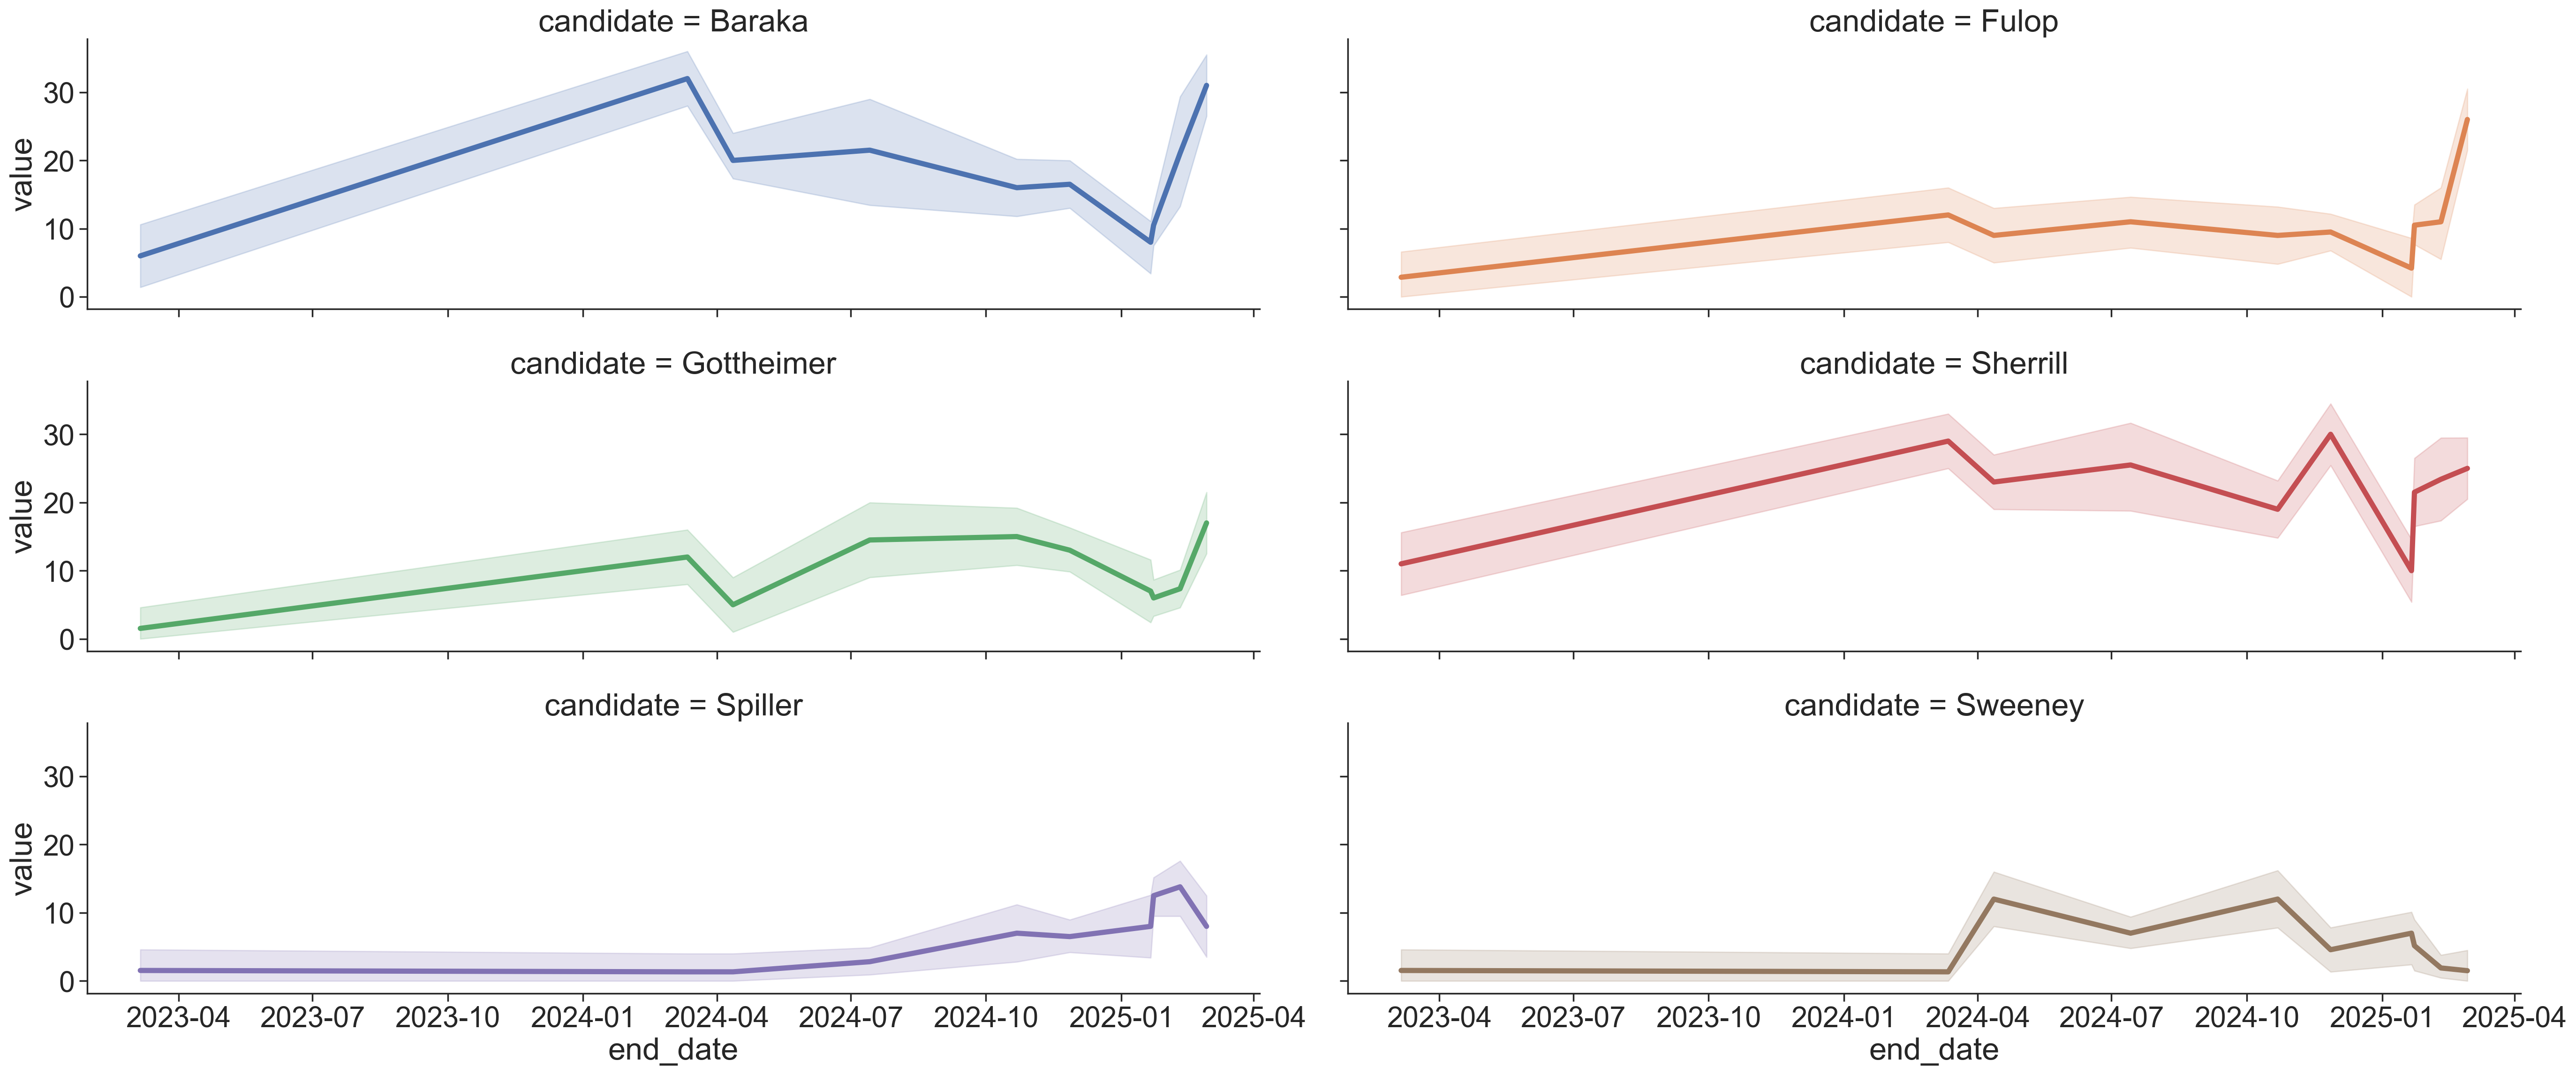

In [5]:
for_plot = df[["end_date", "candidate", "partisan", "pct", "pct_lower", "pct_upper"]].copy()
for_plot = for_plot.melt(id_vars=["end_date", "candidate", "partisan"])

ax = sns.relplot(data=for_plot[for_plot["candidate"] != "Undecided"], x="end_date", y="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="line", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

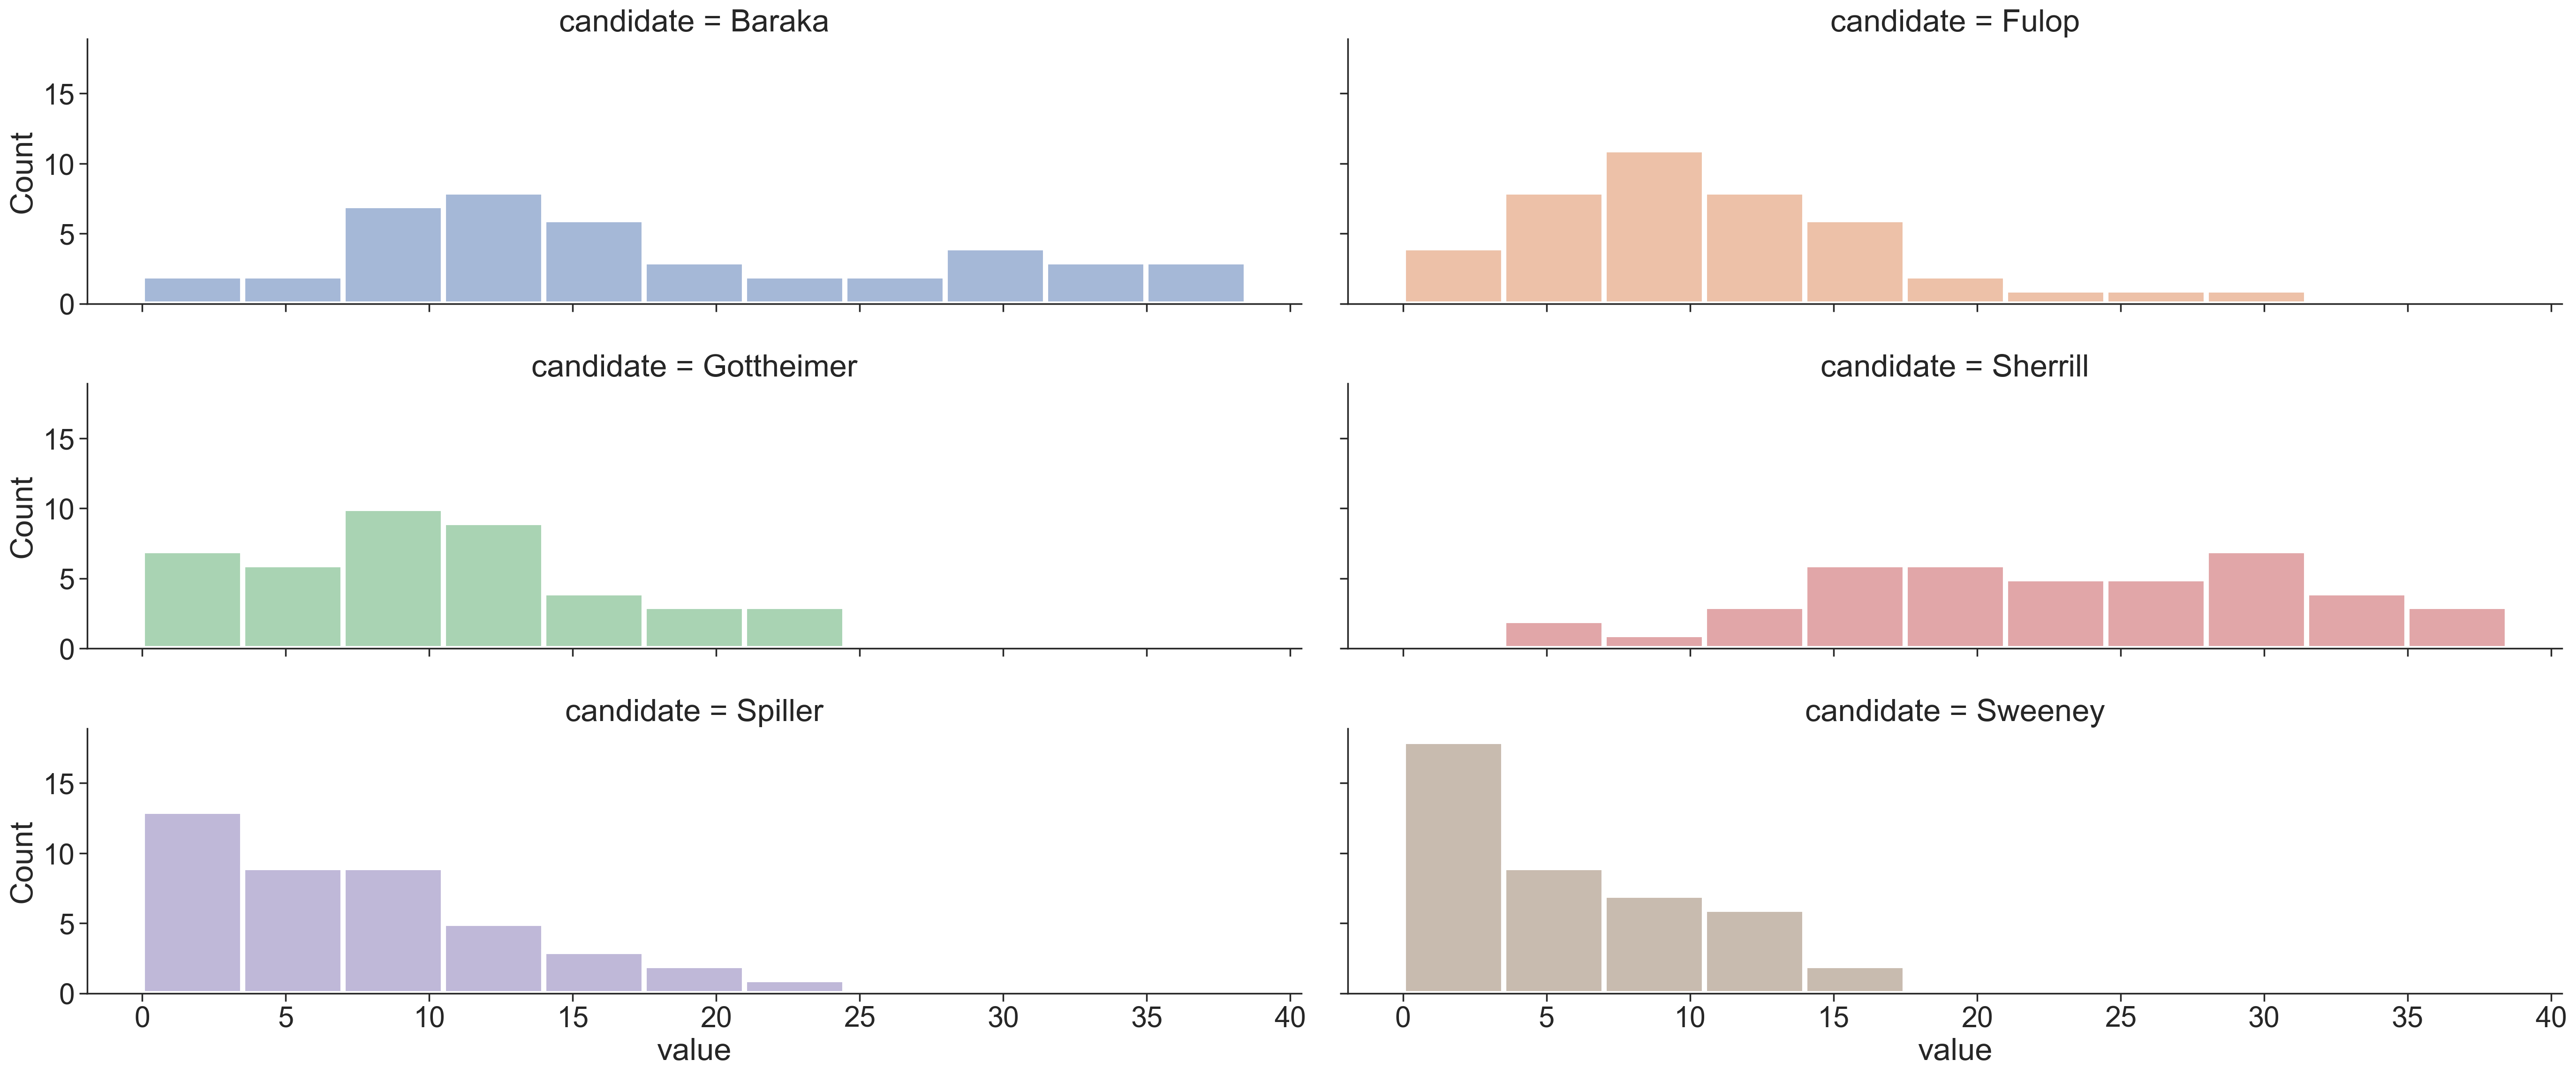

In [6]:
ax = sns.displot(data=for_plot[for_plot["candidate"] != "Undecided"], x="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="hist", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

In [7]:
(for_plot.groupby(["candidate", "partisan"]).agg({"value" : "mean"}).reset_index()
 .pivot(index="candidate", columns="partisan", values="value"))

partisan            0     Baraka        Dem   Sherrill    Spiller
candidate                                                        
Baraka      15.250000  21.275000  16.500000  26.000000  10.500000
Fulop       10.516667  11.000000   9.500000  10.500000  10.500000
Gottheimer  10.133333  10.925000  13.000000   8.500000   6.000000
Sherrill    16.250000  24.450000  30.000000  26.000000  21.500000
Spiller      6.133333   8.310000   6.500000   1.333333  12.500000
Sweeney      5.508333   4.450000   4.576667   6.666667   5.166667
Undecided   40.125000  27.313333  20.500000  23.000000  34.500000

In [8]:
df["num_for"] = ((df["pct"] / 100) * df["sample_size"]).round(0)
df["num_for_lower"] = ((df["pct_lower"] / 100) * df["sample_size"]).round(0)
df["num_for_upper"] = ((df["pct_upper"] / 100) * df["sample_size"]).round(0)

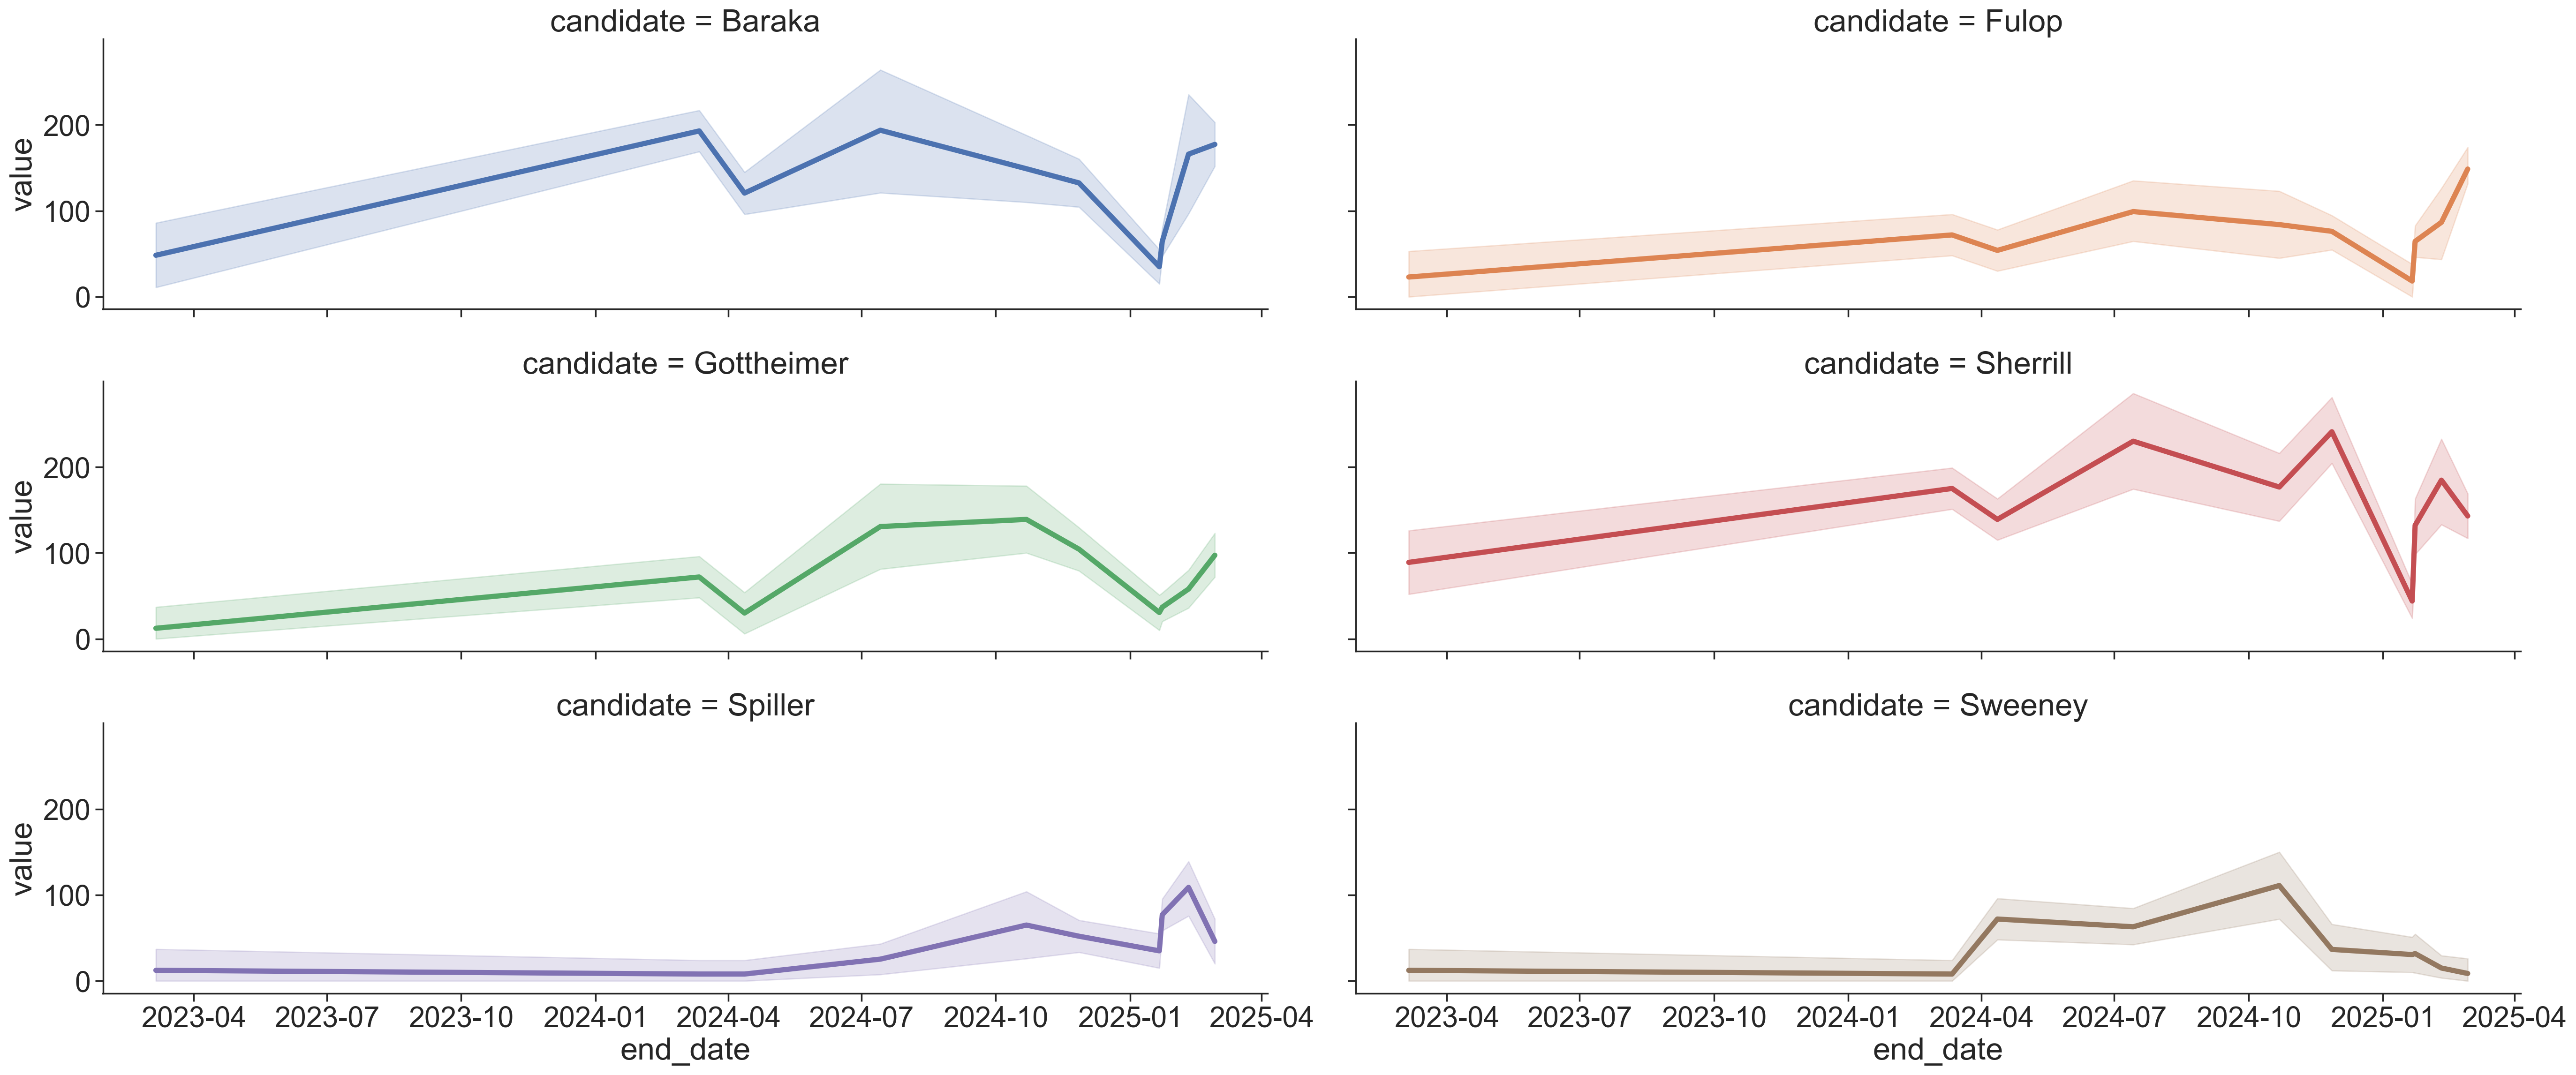

In [9]:
for_plot = df[["end_date", "candidate", "num_for", "num_for_lower", "num_for_upper"]].copy()
for_plot = for_plot.melt(id_vars=["end_date", "candidate"])

ax = sns.relplot(data=for_plot[for_plot["candidate"] != "Undecided"], x="end_date", y="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="line", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

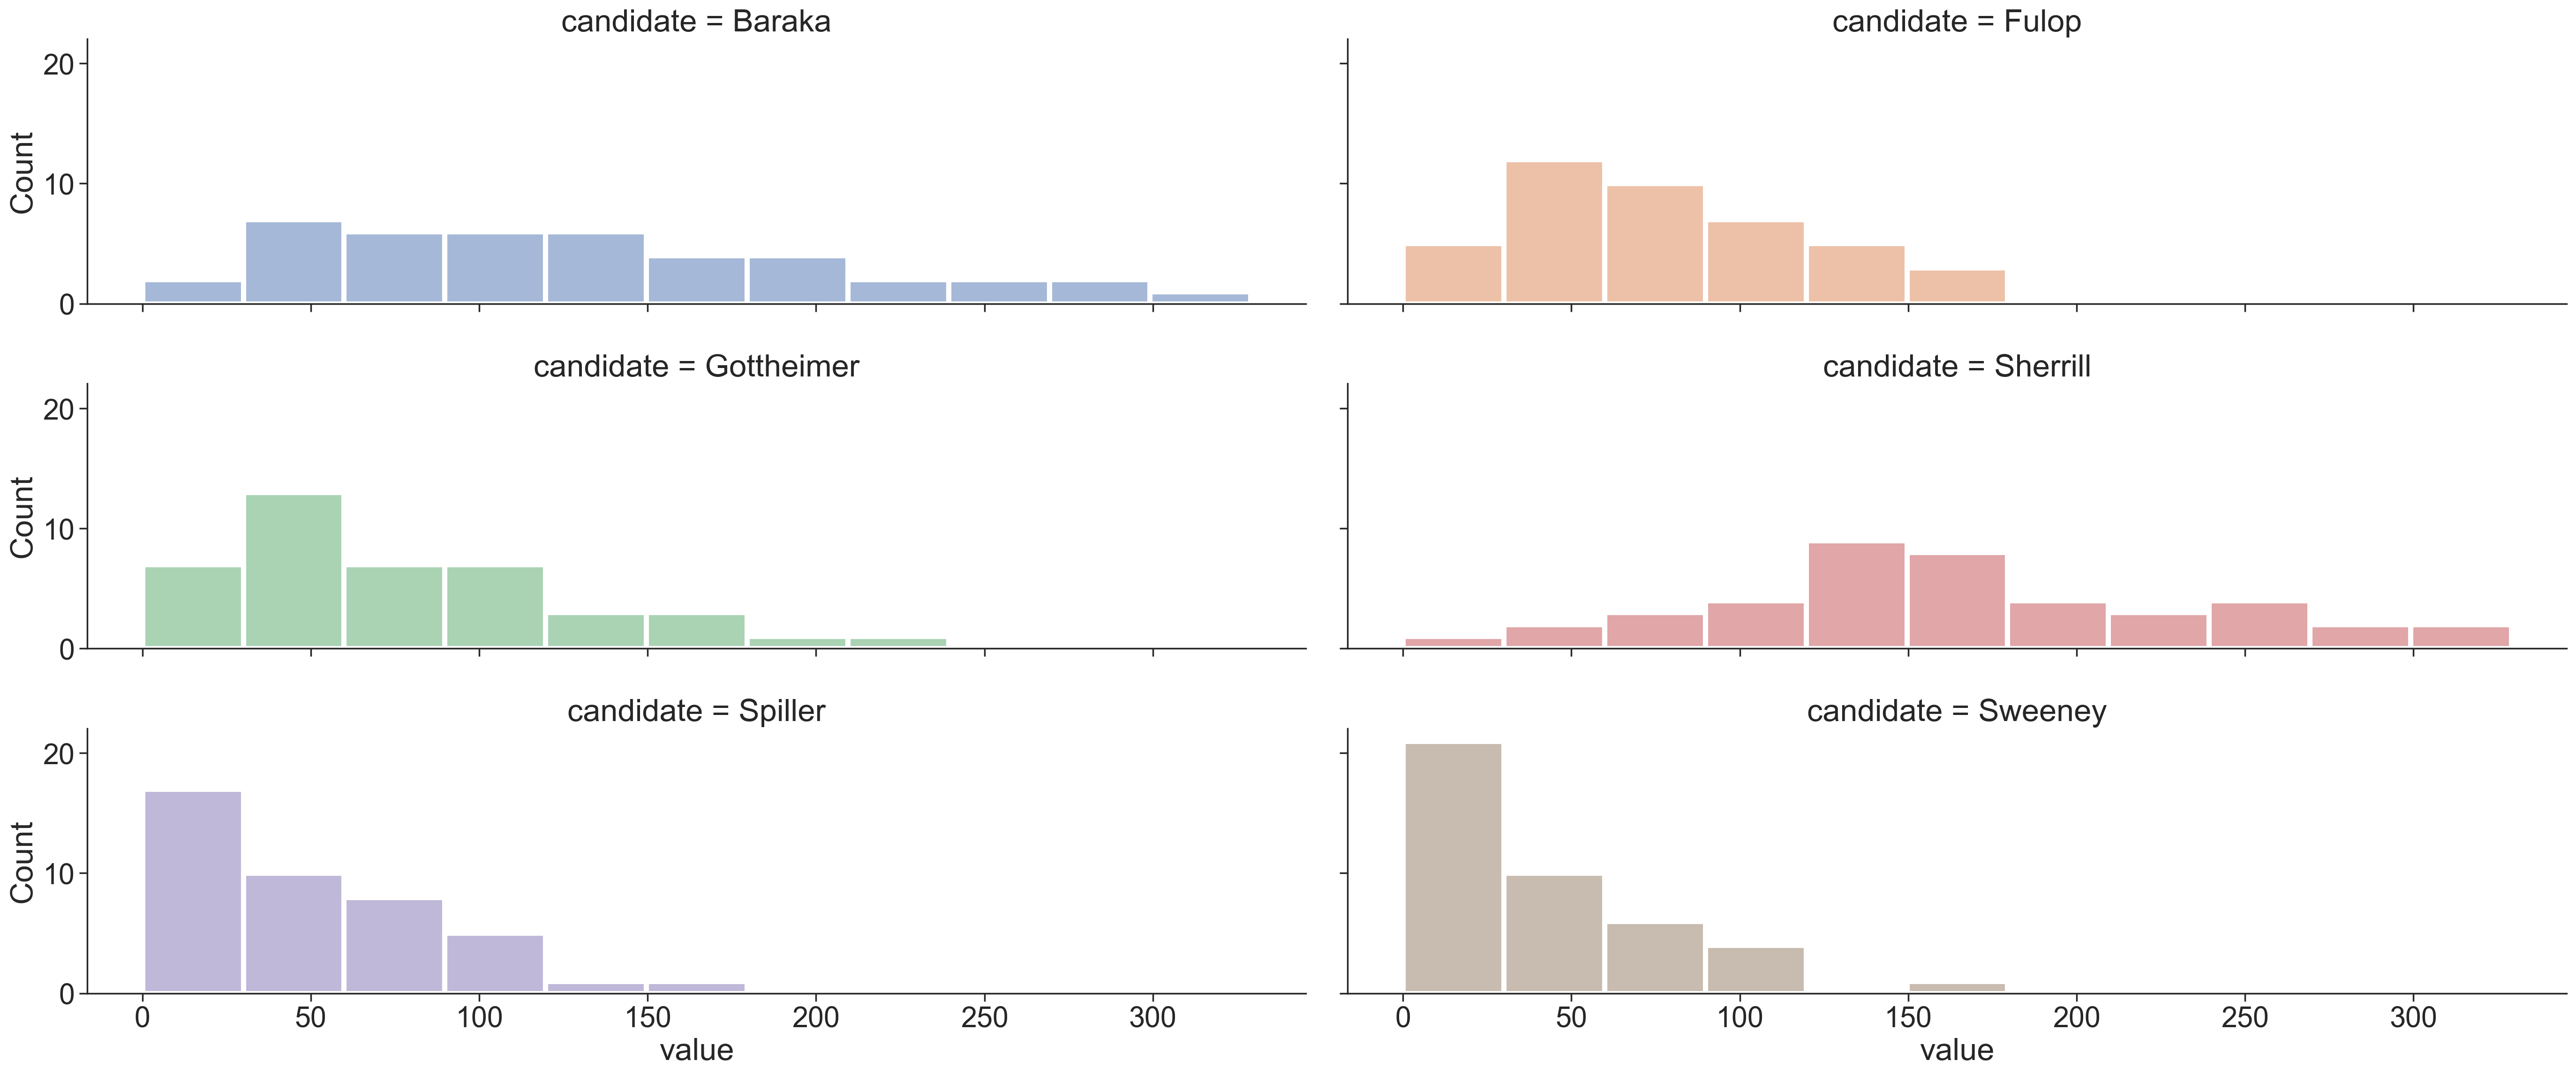

In [10]:
ax = sns.displot(data=for_plot[for_plot["candidate"] != "Undecided"], x="value", col="candidate", col_wrap=2,
                 hue="candidate", kind="hist", legend=False, aspect=3.5, height=4, linewidth=4)
plt.tight_layout()

In [11]:
df["mode"].value_counts()

mode
unknown                    28
text-to-web                28
phone/text-to-web          14
voterfile                  14
panel                       7
phone/text-to-web/panel     7
Name: count, dtype: int64

In [12]:
df["population"].value_counts()

population
lv     70
rv     21
vap     7
Name: count, dtype: int64

---

In [13]:
# based on https://alexandorra.github.io/pollsposition_blog/popularity/macron/hidden%20markov%20models/polls/2021/05/16/hmm-popularity.html

In [14]:
df = df.melt(id_vars=[c for c in df.columns if not c.startswith("num_for")])
df = df.rename(columns={"value" : "num_for"})

# Non-Partisan Polls Only

In [15]:
np_df = df[df["partisan"] == "0"].copy()

In [16]:
month_id, months = np_df["end_date"].dt.to_period("M").factorize(sort=False)
months = [str(m) for m in months]

In [17]:
cand_id, candidates = np_df["candidate"].factorize(sort=False)

In [18]:
coords = {
    "observation" : np_df.index,
    "candidate" : candidates,
    "month" : months,
}

In [19]:
with pm.Model(coords=coords) as model:
    month_effect = pm.Normal("month_effect", 0, 0.15, dims="month")
    shrinkage_pop = pm.HalfNormal("shrinkage_pop", 0.2)
    cand_effect = pm.Normal("candidate_effect", mu=0, sigma=shrinkage_pop, dims="candidate")

    popularity = pm.math.invlogit(month_effect[month_id] + cand_effect[cand_id])

    y_hat = pm.Binomial(
        "y_hat",
        p=popularity,
        n=np_df["sample_size"],
        observed=np_df["num_for"],
        dims="observation",
    )

In [20]:
with model:
    idata = pm.sample(extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [month_effect, shrinkage_pop, candidate_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


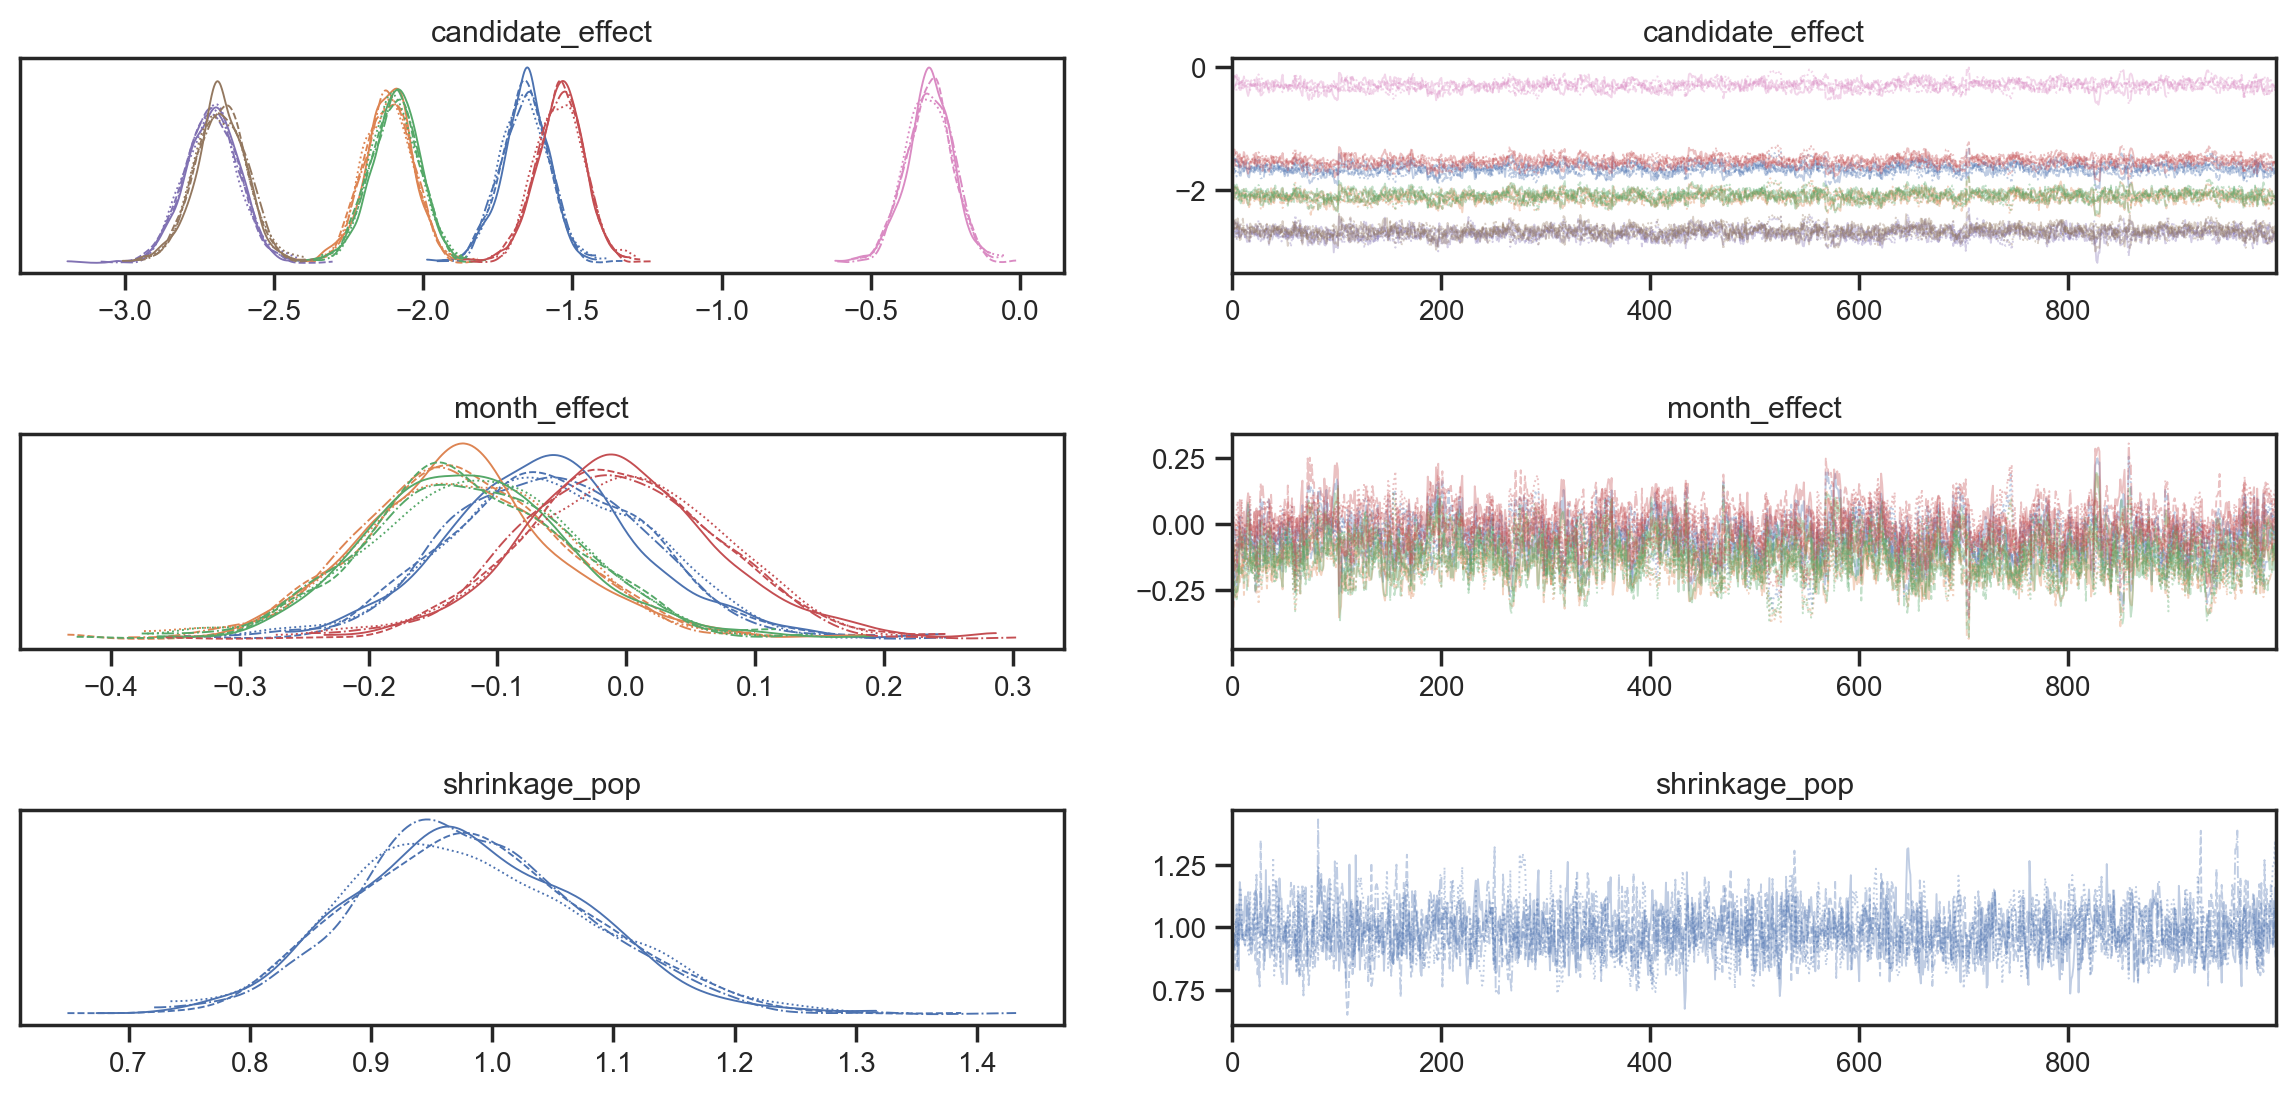

In [21]:
az.plot_trace(idata);
plt.tight_layout()

In [22]:
with model:
    pred_oos = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Output()

In [23]:
cand_preds = {}

for c in idata.posterior.coords["candidate"]:
    post = idata.posterior.sel(candidate=c)
    post_pop = expit(post["month_effect"] +
                     post["candidate_effect"]).stack(sample=("chain", "draw"))
    cand_preds[str(c.values)] = post_pop.mean(axis=0)

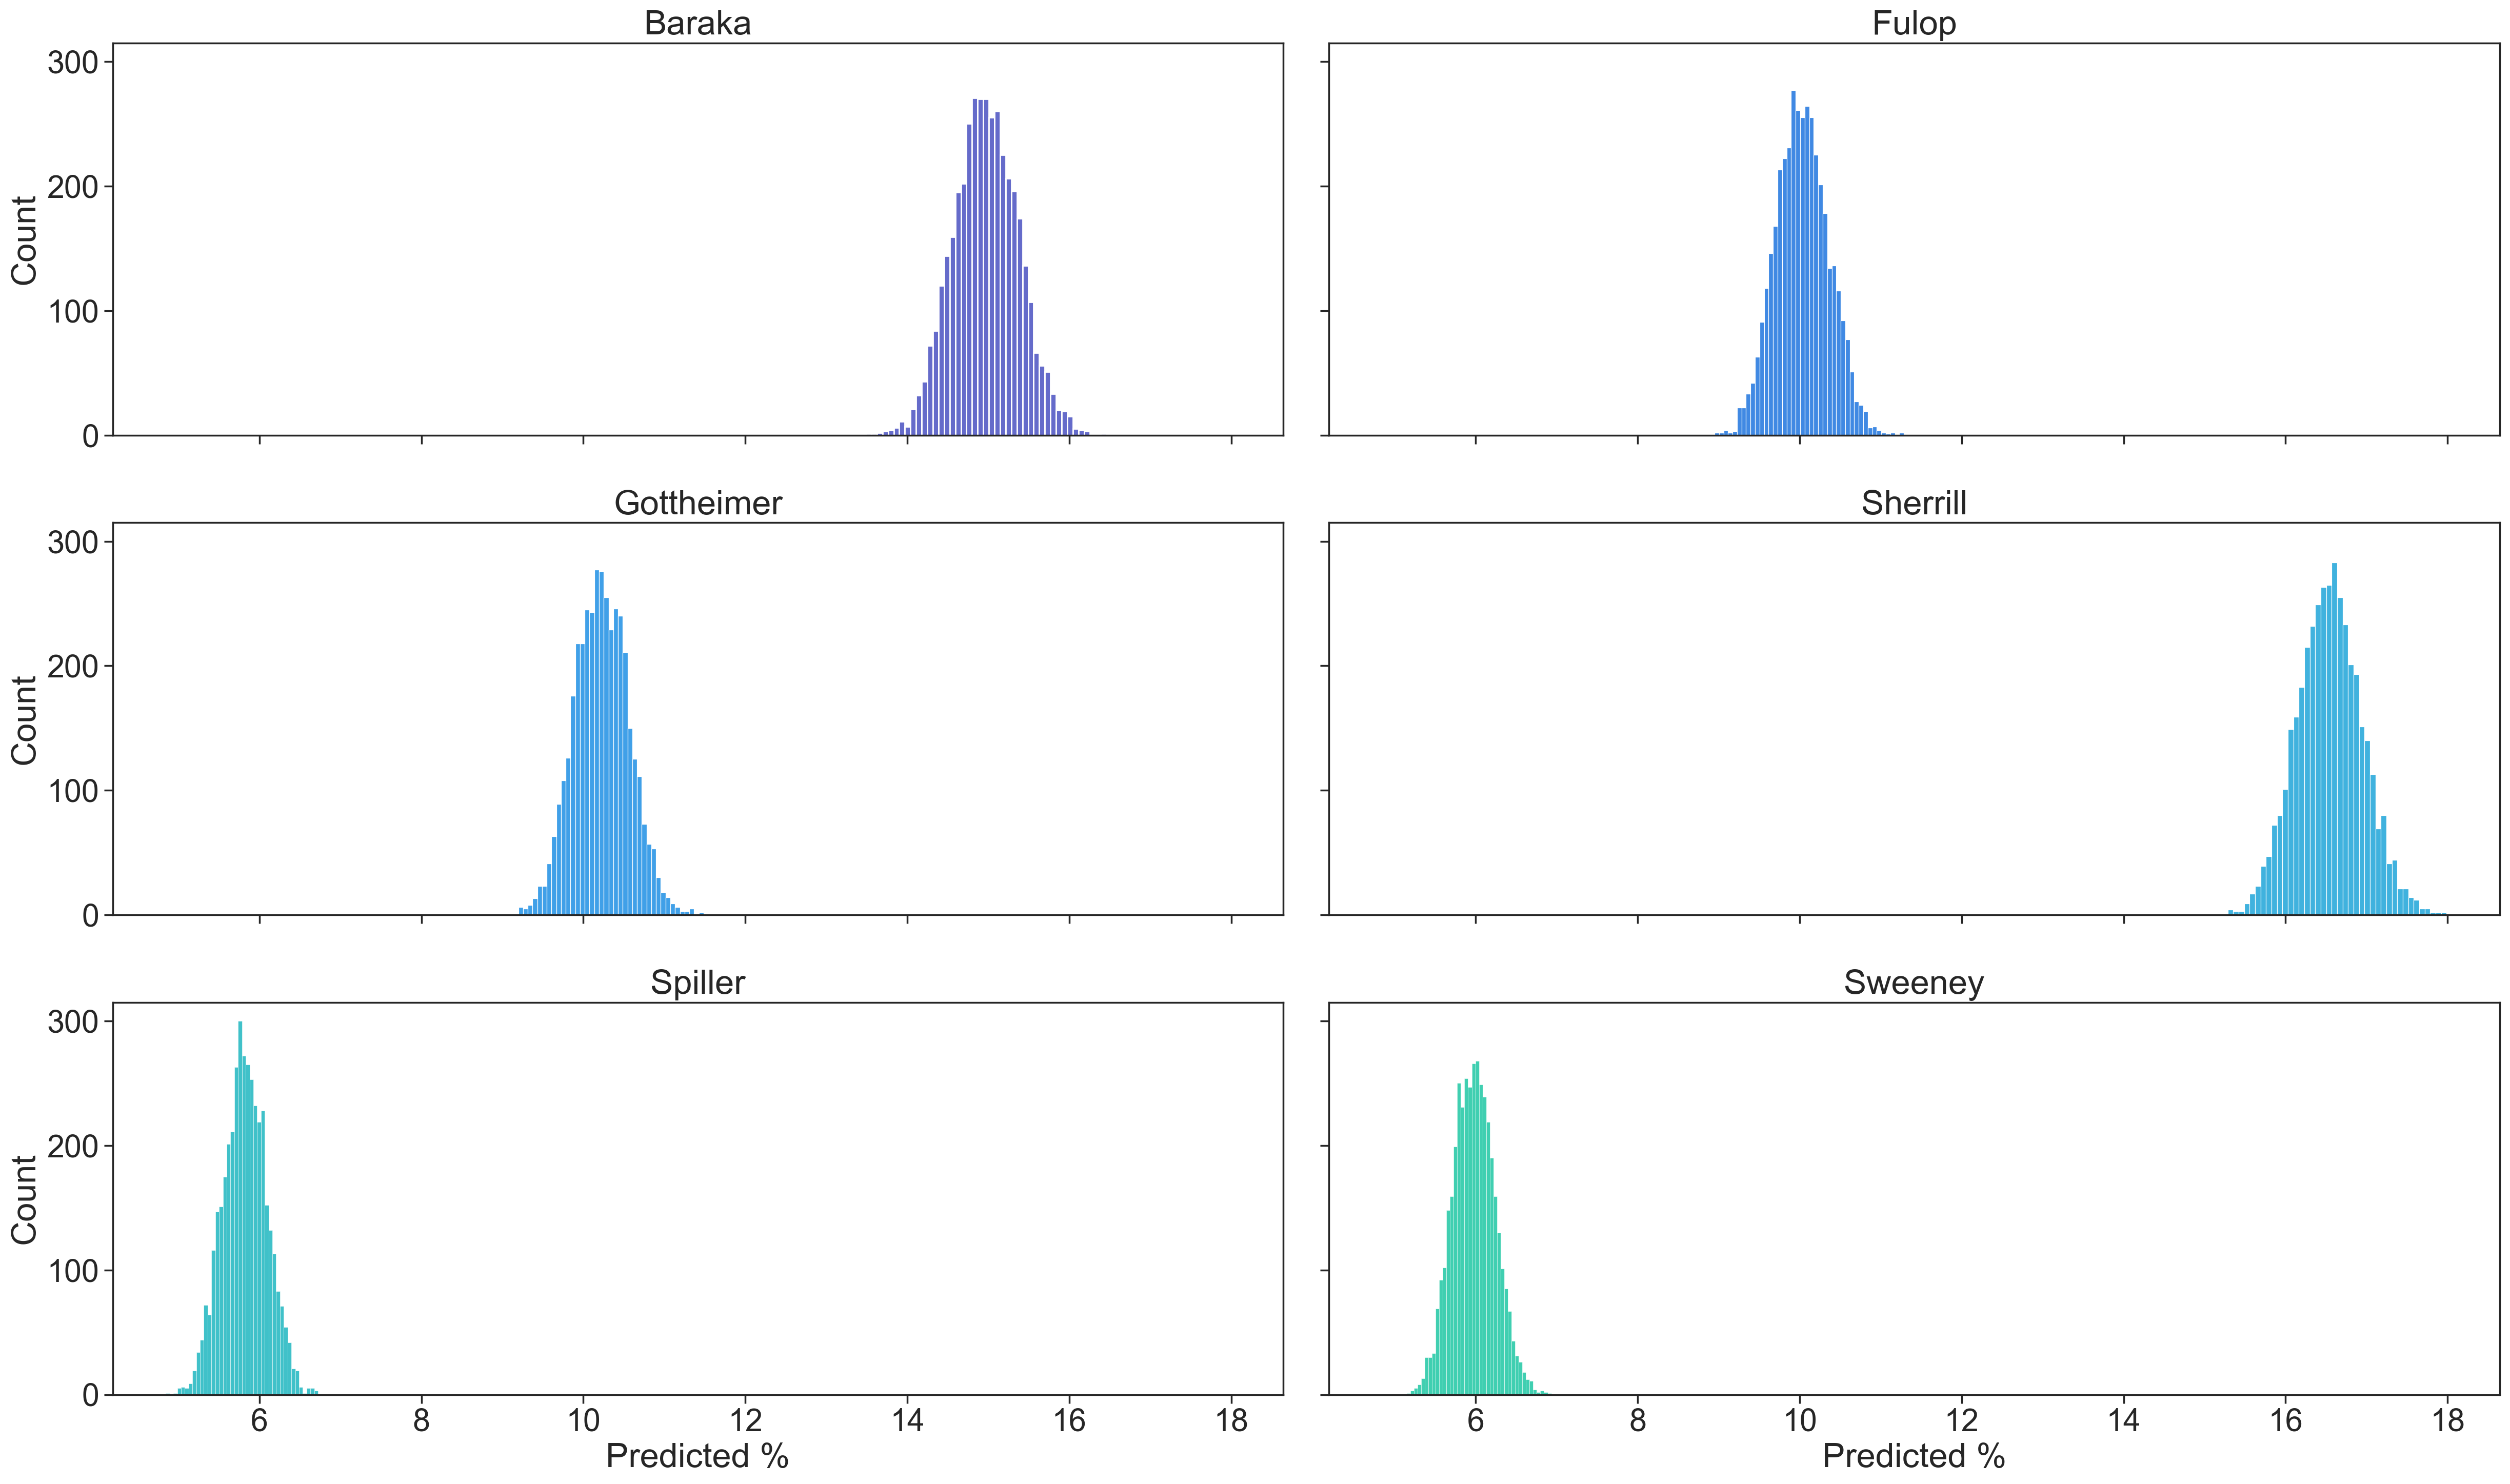

In [24]:
(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True)
colors = ["#323ab9", "#0062da", "#0080e1", "#0098d3", "#00adb7", "#00c097"]

for ((cand, ax), color) in zip(zip(cand_preds, axs.ravel()), colors):
    sns.histplot(x=cand_preds[cand] * 100, ax=ax, color=color)
    ax.set_title(cand)
    ax.set_xlabel("Predicted %")

plt.tight_layout()

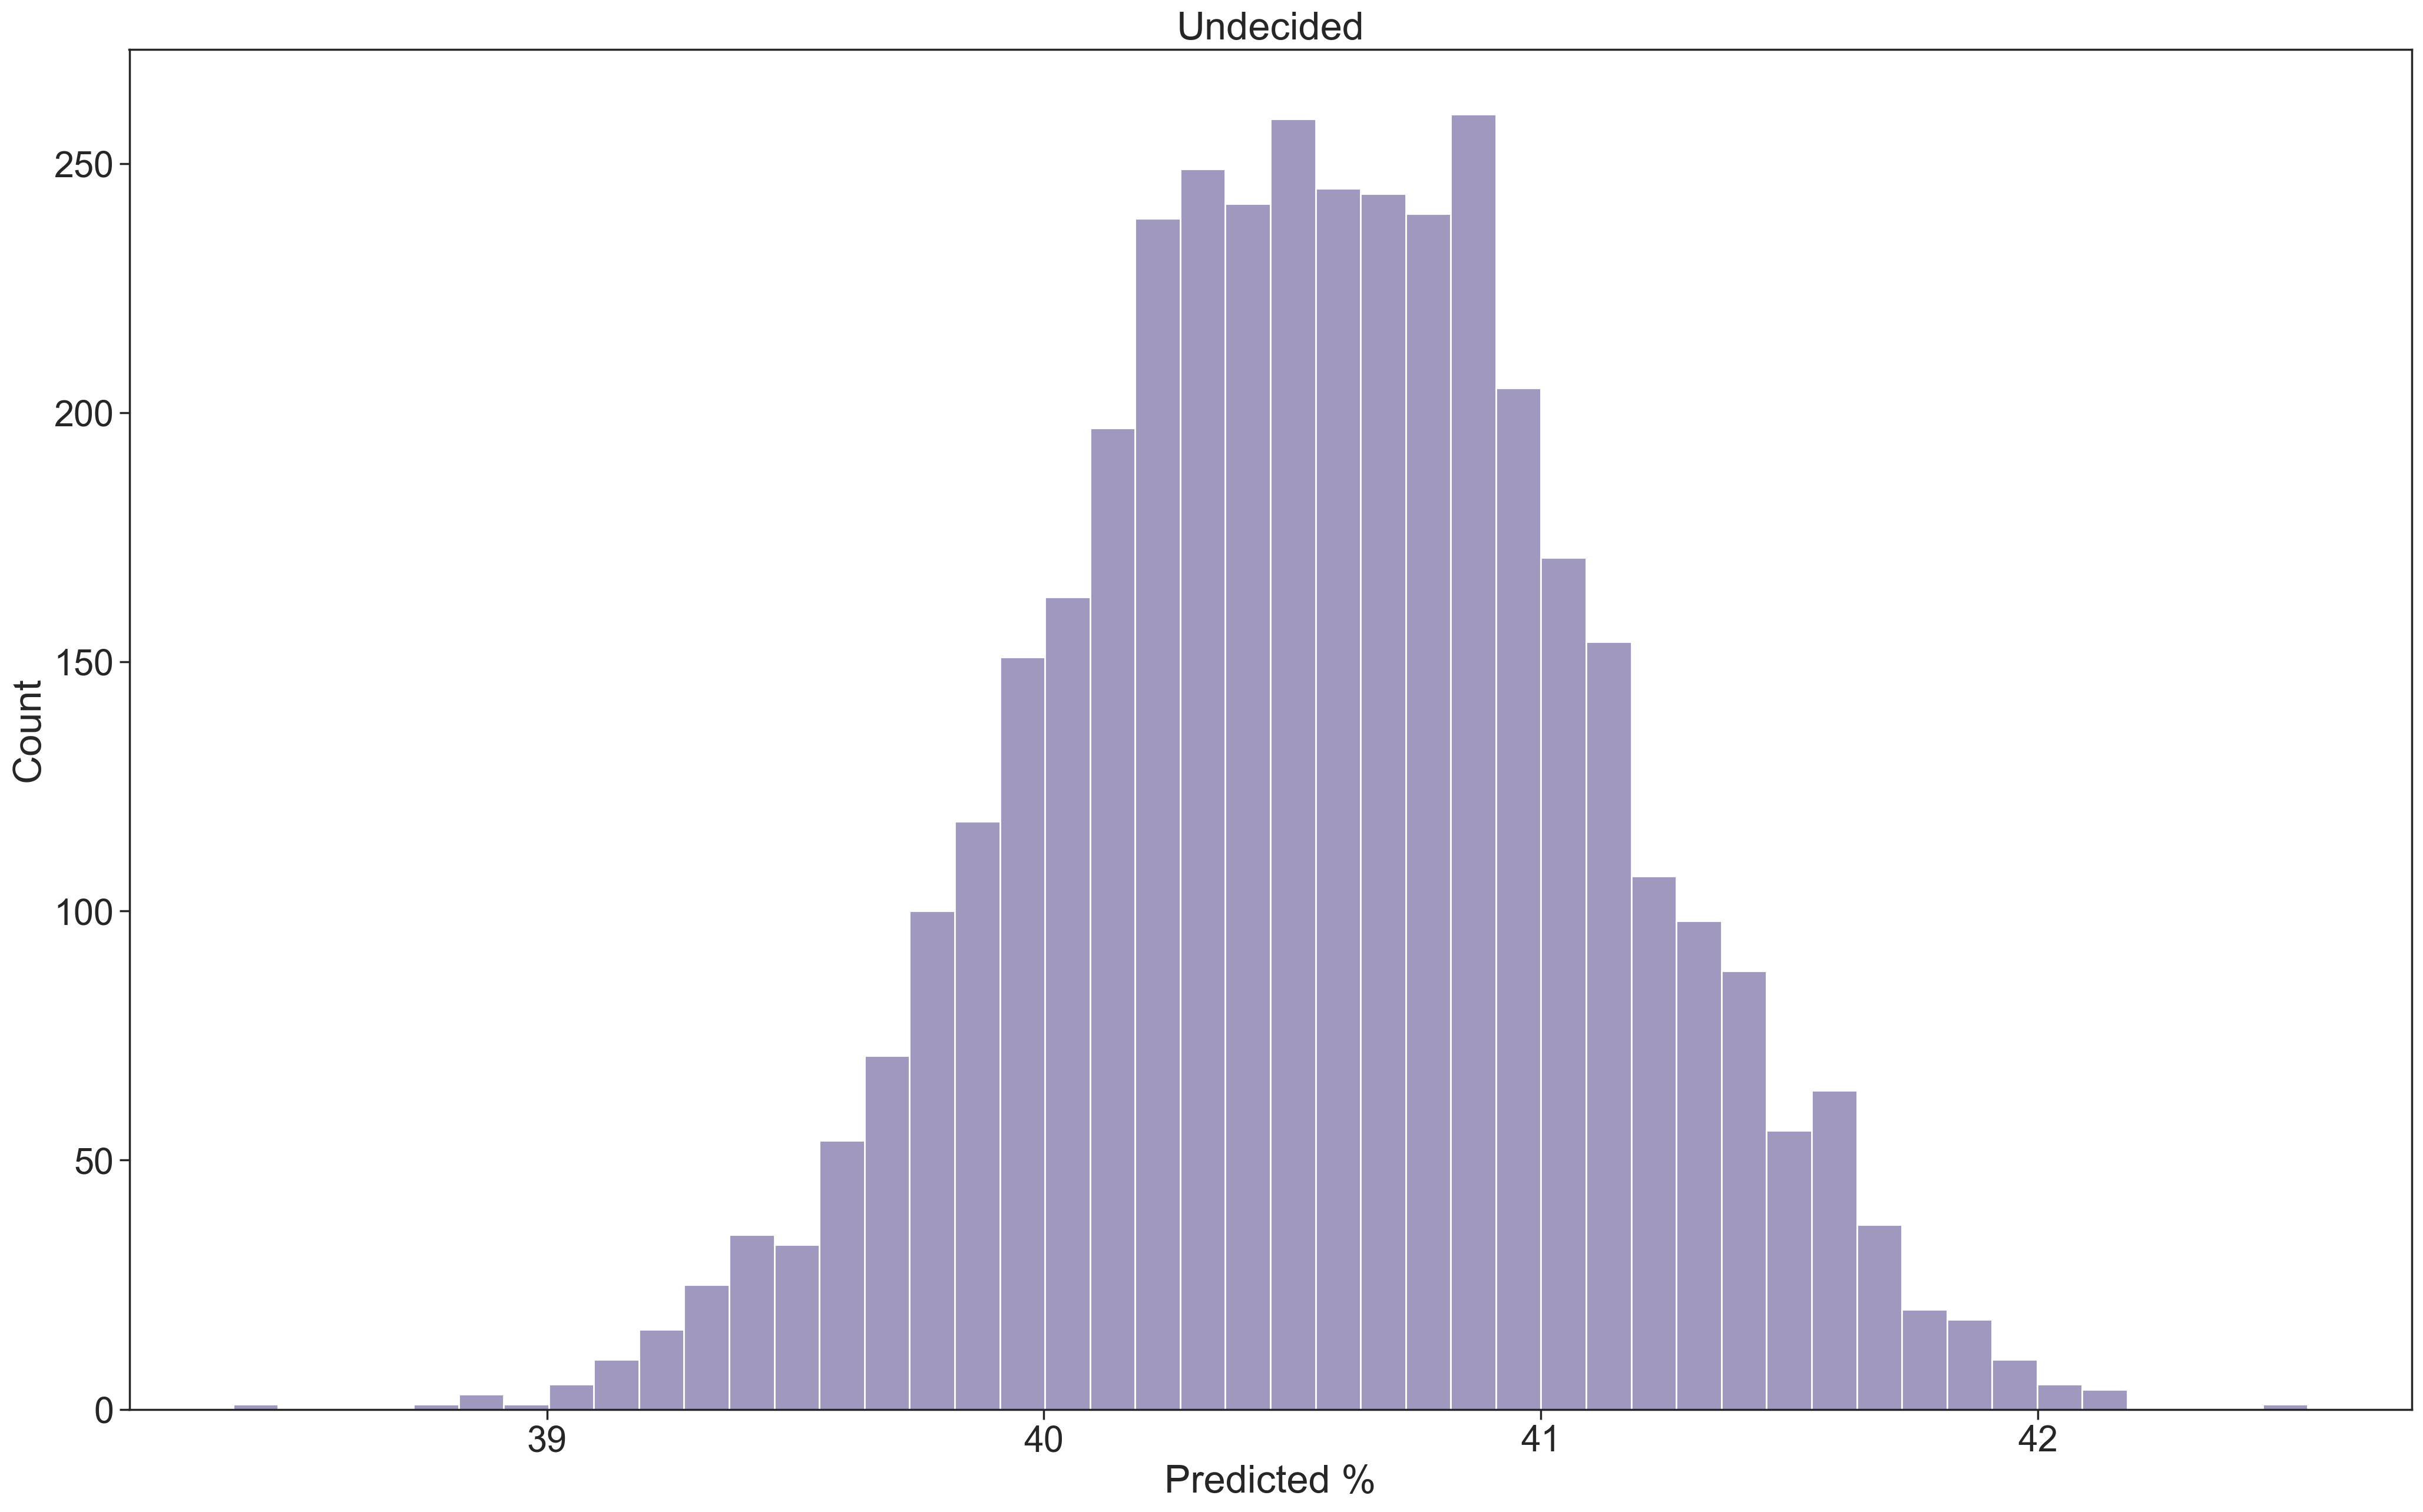

In [25]:
ax = sns.histplot(x=cand_preds["Undecided"] * 100, color="#8076a9")
ax.set_title("Undecided")
ax.set_xlabel("Predicted %")
plt.show()

In [26]:
rows = []
for cand in cand_preds:
    row = {"Candidate" : cand,
           "Pred" : np.mean(cand_preds[cand].values),
           "Lower" : np.quantile(cand_preds[cand], 0.025),
           "Upper" : np.quantile(cand_preds[cand], 0.975)}
    rows.append(row)
pred_df = pandas.DataFrame(rows)

In [27]:
pred_df.sort_values(by=["Pred"], ascending=False)

Candidate      Pred     Lower     Upper
6   Undecided  0.405591  0.394679  0.416228
3    Sherrill  0.165432  0.157612  0.173475
0      Baraka  0.149695  0.142040  0.157654
2  Gottheimer  0.102241  0.095795  0.108847
1       Fulop  0.100306  0.094085  0.106618
5     Sweeney  0.059740  0.054696  0.065001
4     Spiller  0.058168  0.052930  0.063492

# All Polls (Including Partisan)

In [28]:
cand_id, candidates = df["candidate"].factorize(sort=False)

In [29]:
# kind_id, kinds = df["kind"].factorize(sort=False)

In [30]:
partisan_id, partisans = df["partisan"].factorize(sort=False)

In [31]:
month_id, months = df["end_date"].dt.to_period("M").factorize(sort=False)
months = [str(m) for m in months]

In [32]:
coords = {
    "observation" : df.index,
    "candidate" : candidates,
    "partisan" : partisans,
    "month" : months,
    # "kind" : kinds
}

In [33]:
with pm.Model(coords=coords) as model:
    # kind_effect = pm.Normal("kind_effect", 0, 0.15, dims="kind")
    # partisan_effect = pm.Normal("partisan_effect", 0, 0.15, dims="partisan")
    partisan_effect = pm.Beta("partisan_effect", alpha=2, beta=5, dims="partisan")
    month_effect = pm.Normal("month_effect", 0, 0.15, dims="month")
    shrinkage_pop = pm.HalfNormal("shrinkage_pop", 0.2)
    cand_effect = pm.Normal("candidate_effect", mu=0, sigma=shrinkage_pop, dims="candidate")

    popularity = pm.math.invlogit(partisan_effect[partisan_id] + month_effect[month_id] + cand_effect[cand_id])

    y_hat = pm.Binomial(
        "y_hat",
        p=popularity,
        n=df["sample_size"],
        observed=df["num_for"],
        dims="observation",
    )

In [34]:
with model:
    idata = pm.sample(extend_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [partisan_effect, month_effect, shrinkage_pop, candidate_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


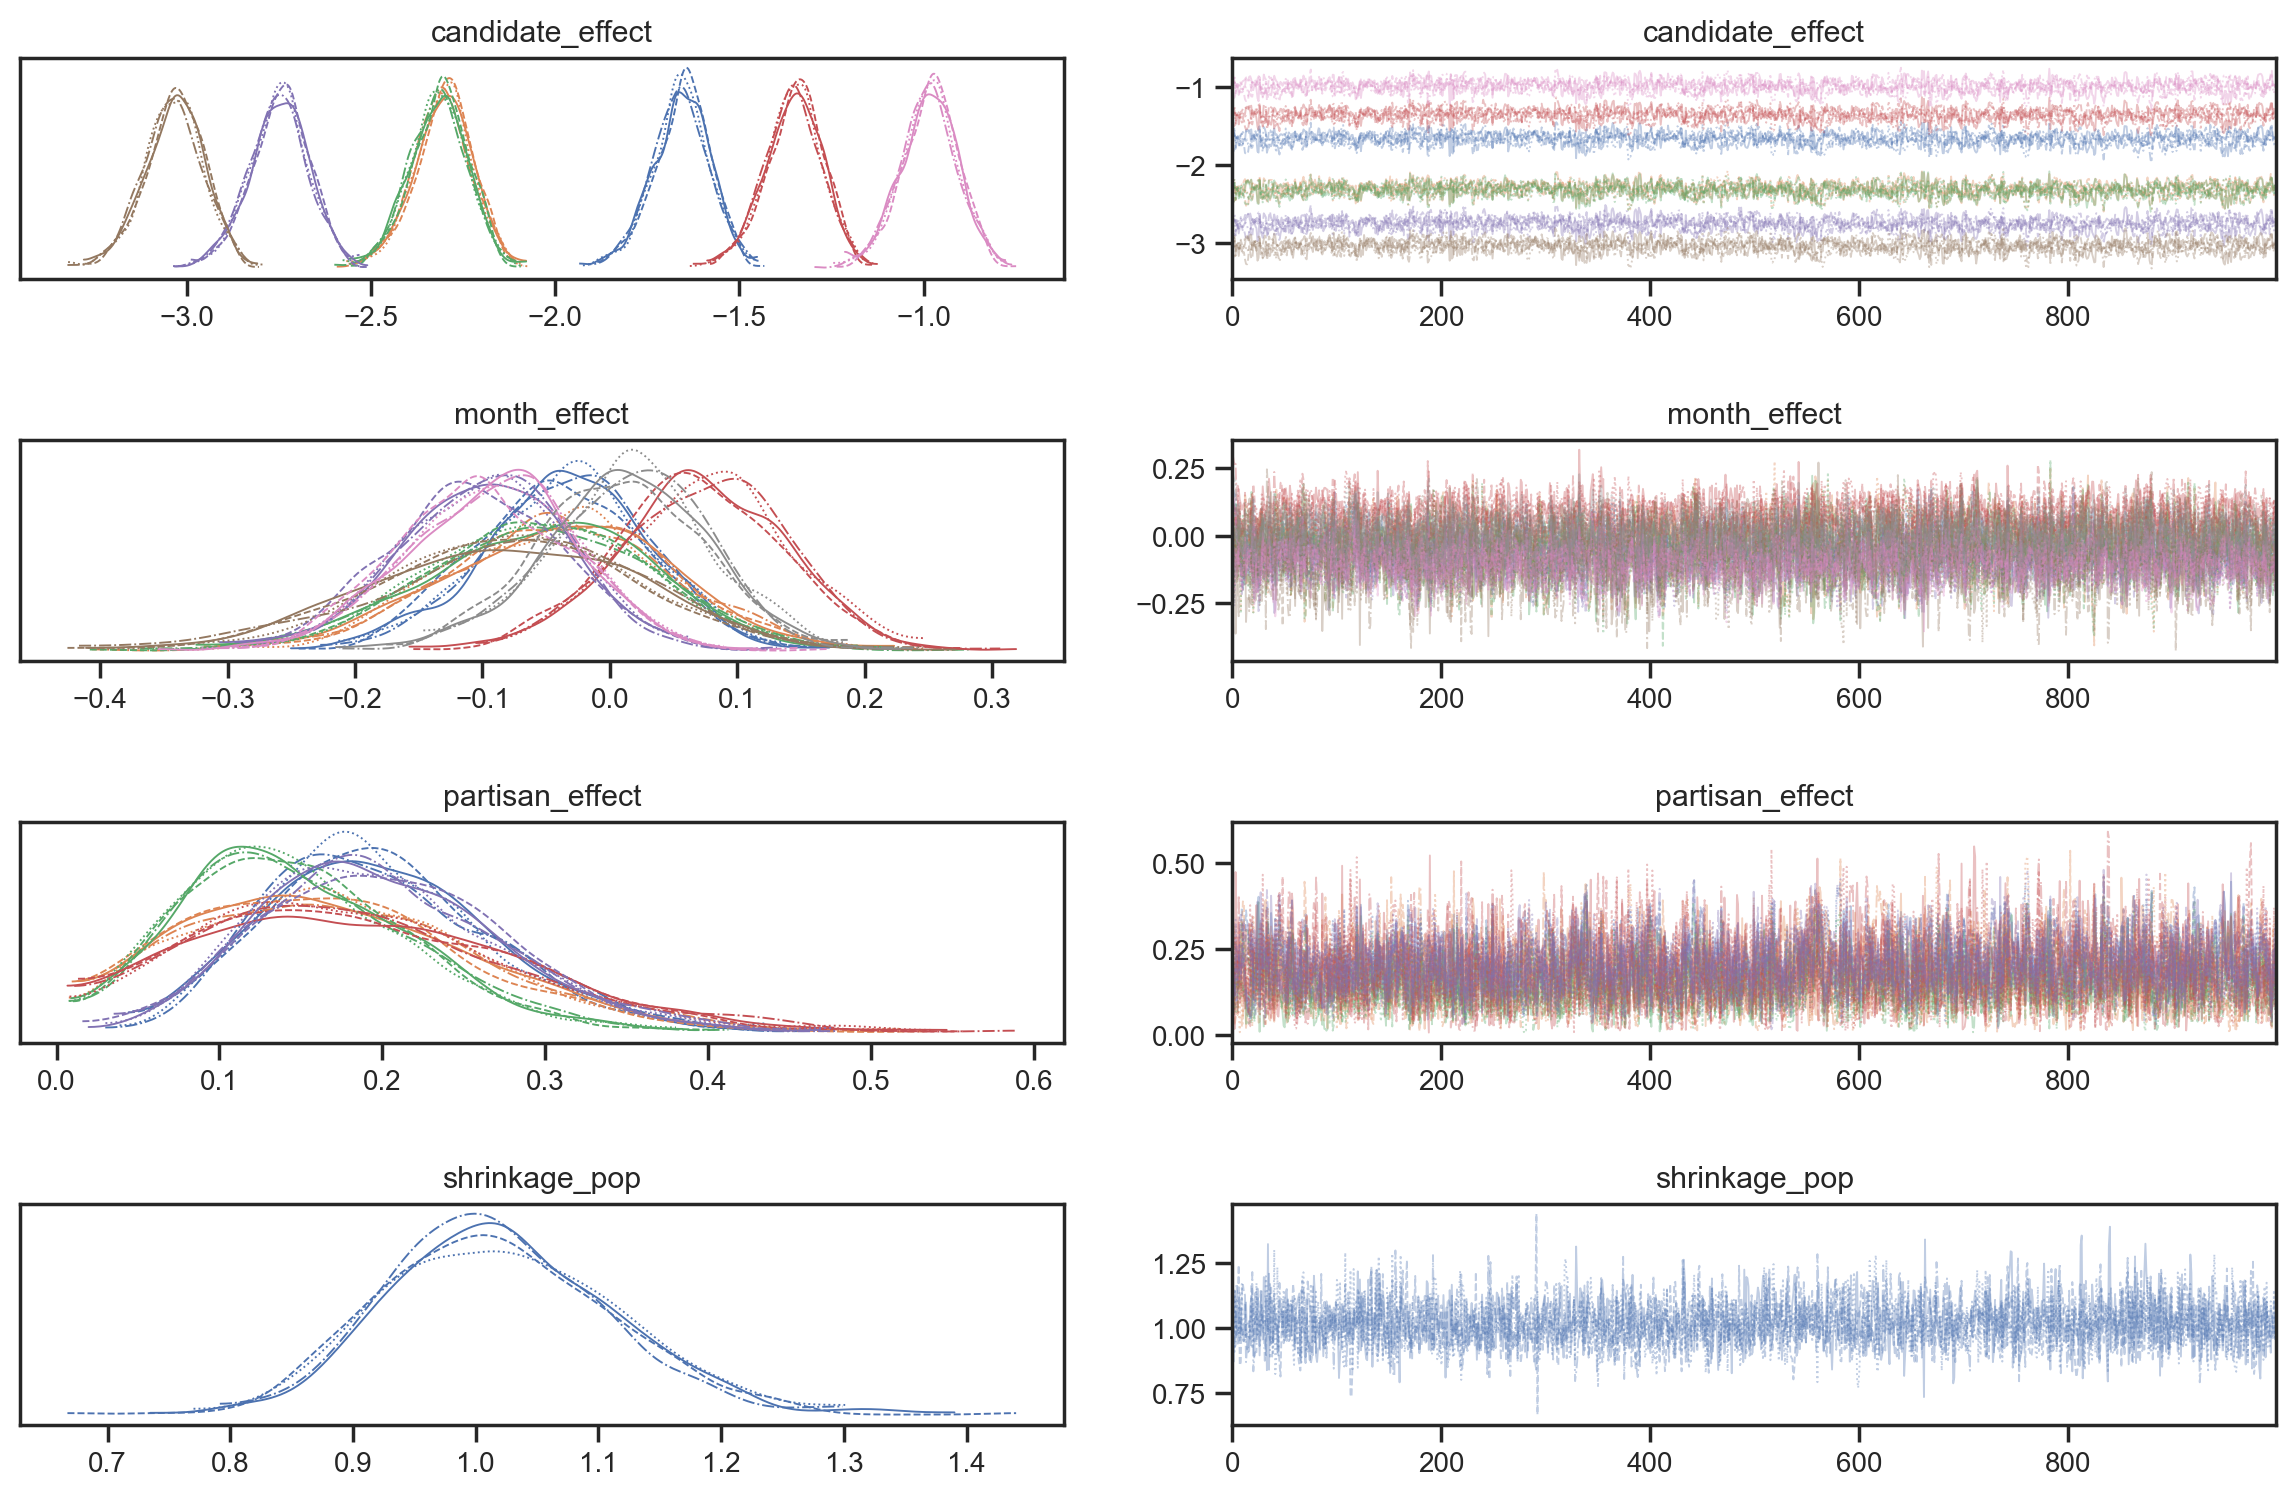

In [35]:
az.plot_trace(idata);
plt.tight_layout()

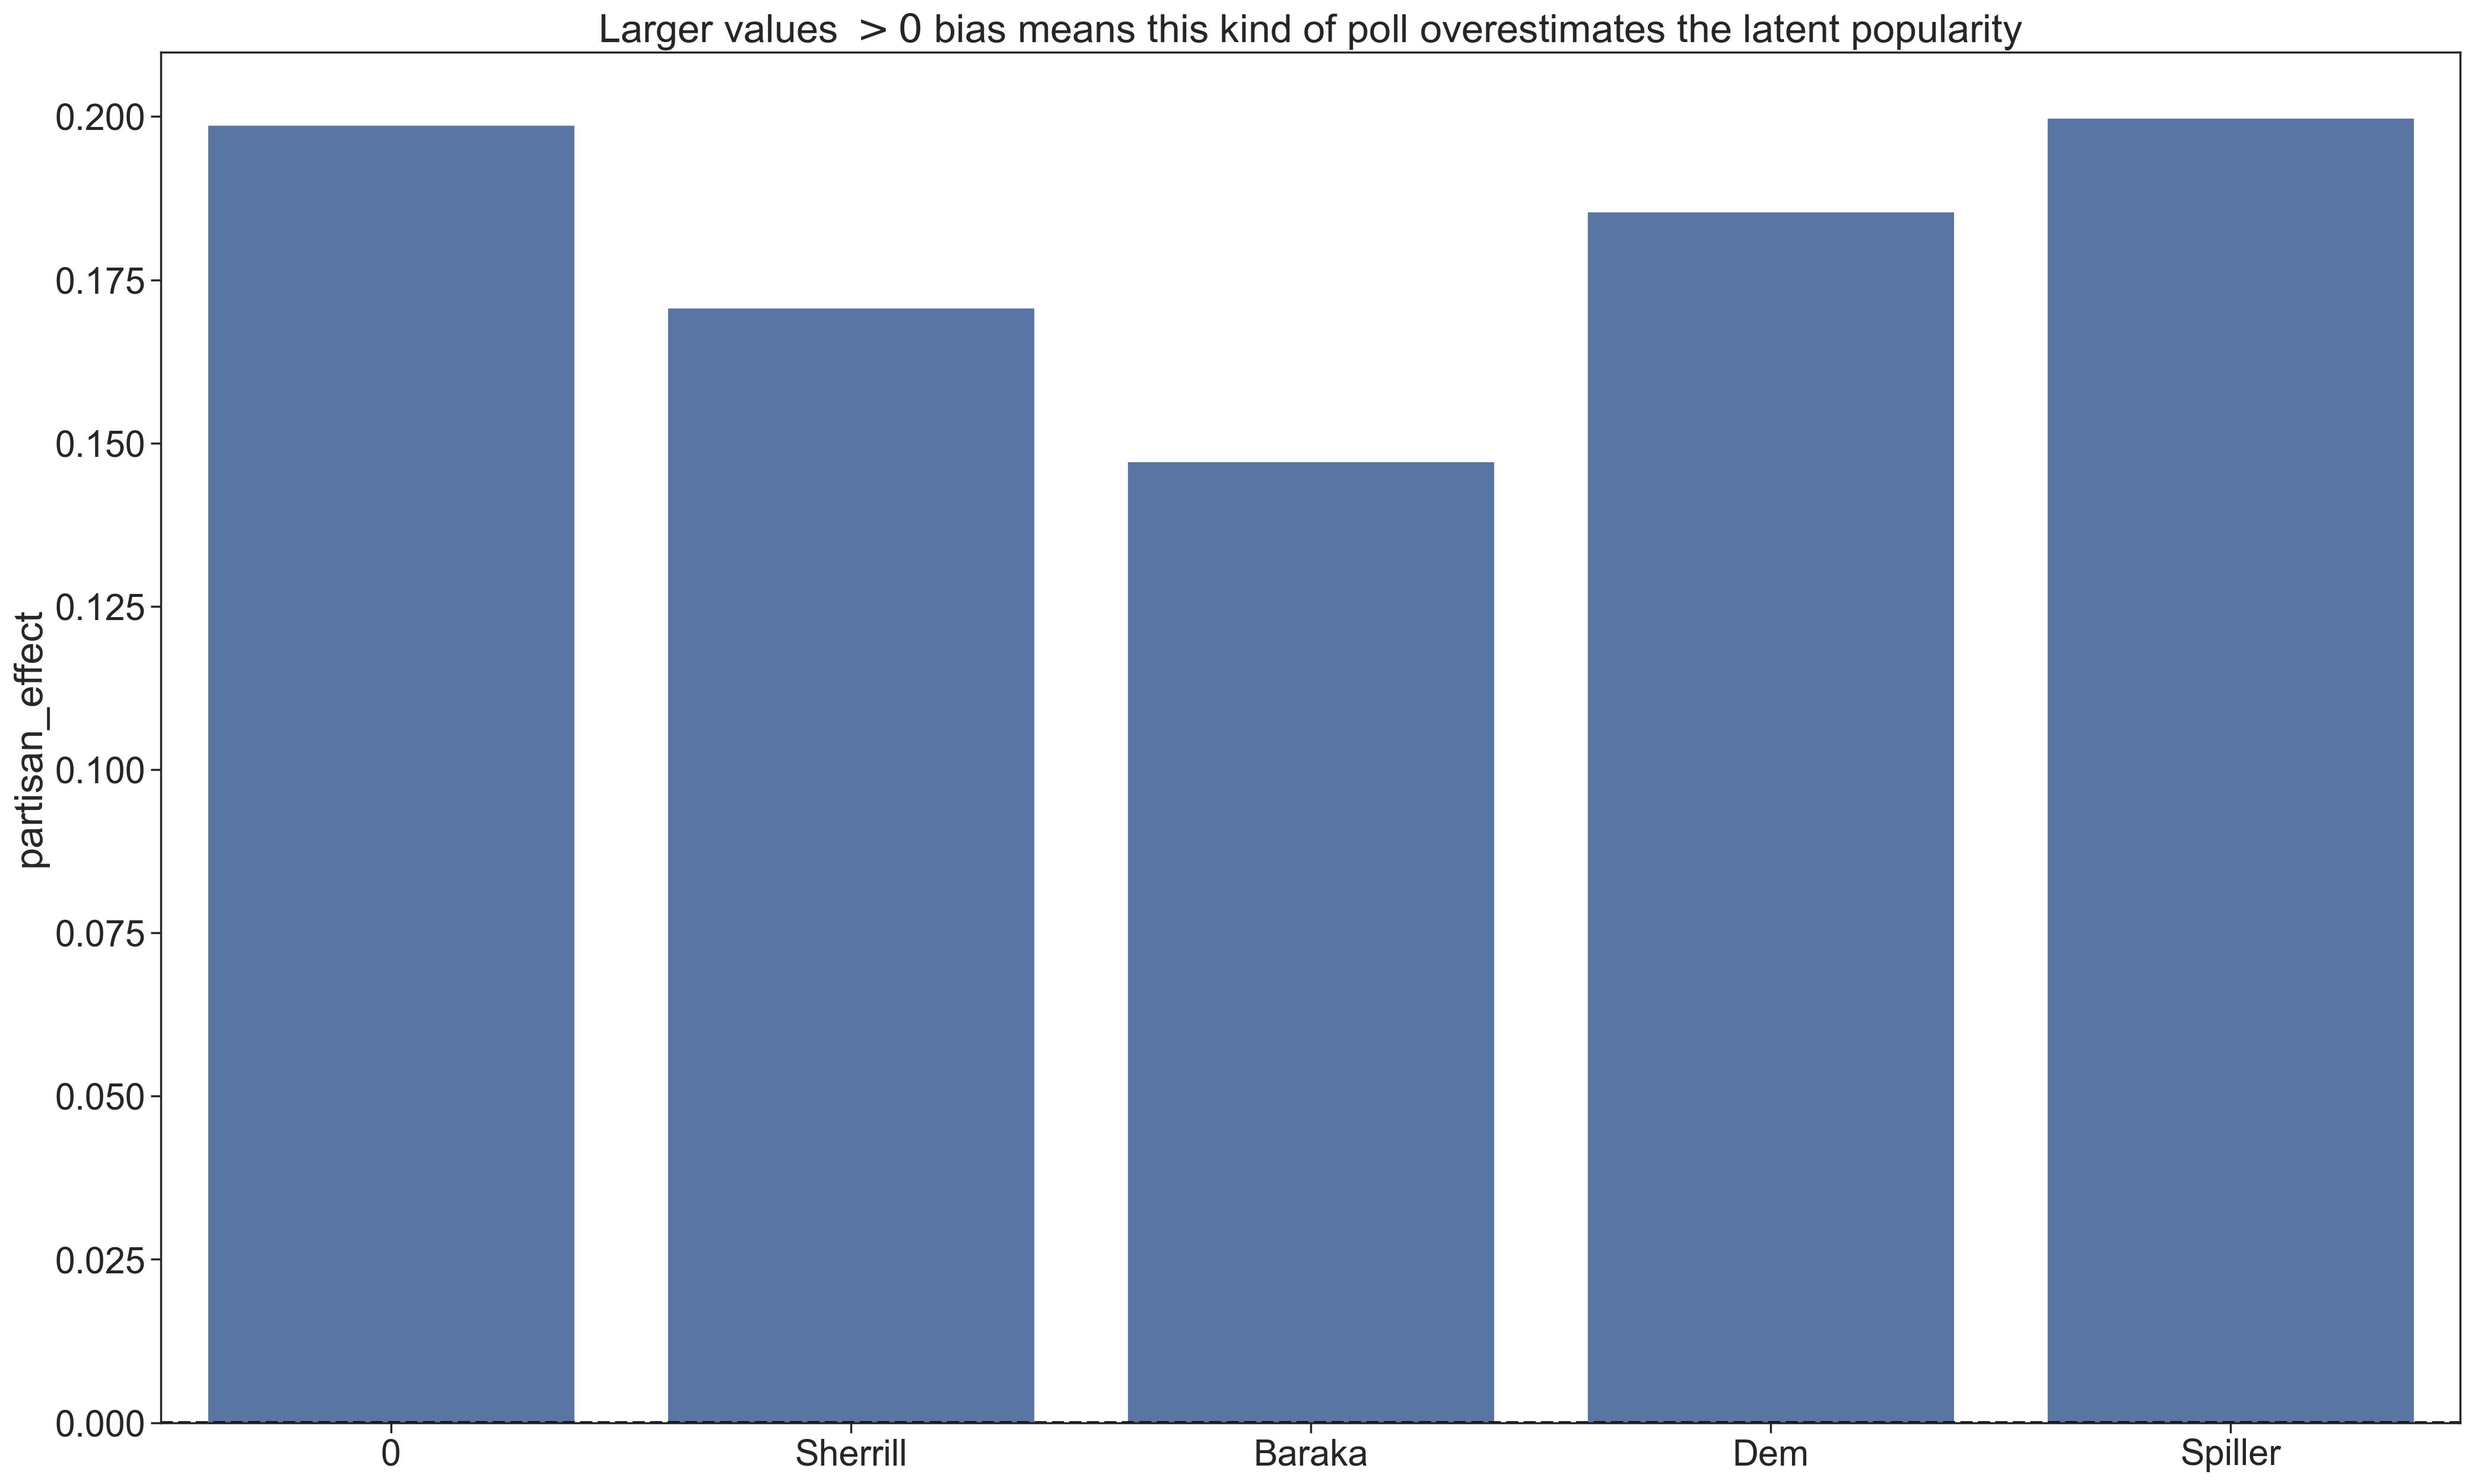

In [36]:
mean_kind_effect = (idata.posterior["partisan_effect"].mean(("chain", "draw")).to_dataframe()).reset_index()
ax = sns.barplot(data=mean_kind_effect, x="partisan", y="partisan_effect")
ax.axhline(0, color="black", linestyle="--", linewidth=2)
ax.set_title("Larger values $>0$ bias means this kind of poll overestimates the latent popularity")
ax.set_xlabel(None)
plt.show()

In [37]:
with model:
    pred_oos = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

Sampling: [y_hat]


Output()

In [38]:
cand_preds = {}

for c in idata.posterior.coords["candidate"]:
    post = idata.posterior.sel(candidate=c)
    post_pop = expit(post["partisan_effect"] +
                     post["month_effect"] +
                     post["candidate_effect"]).stack(sample=("chain", "draw"))
    cand_preds[str(c.values)] = dict(zip(post["partisan"].values, post_pop.mean(axis=1).values))

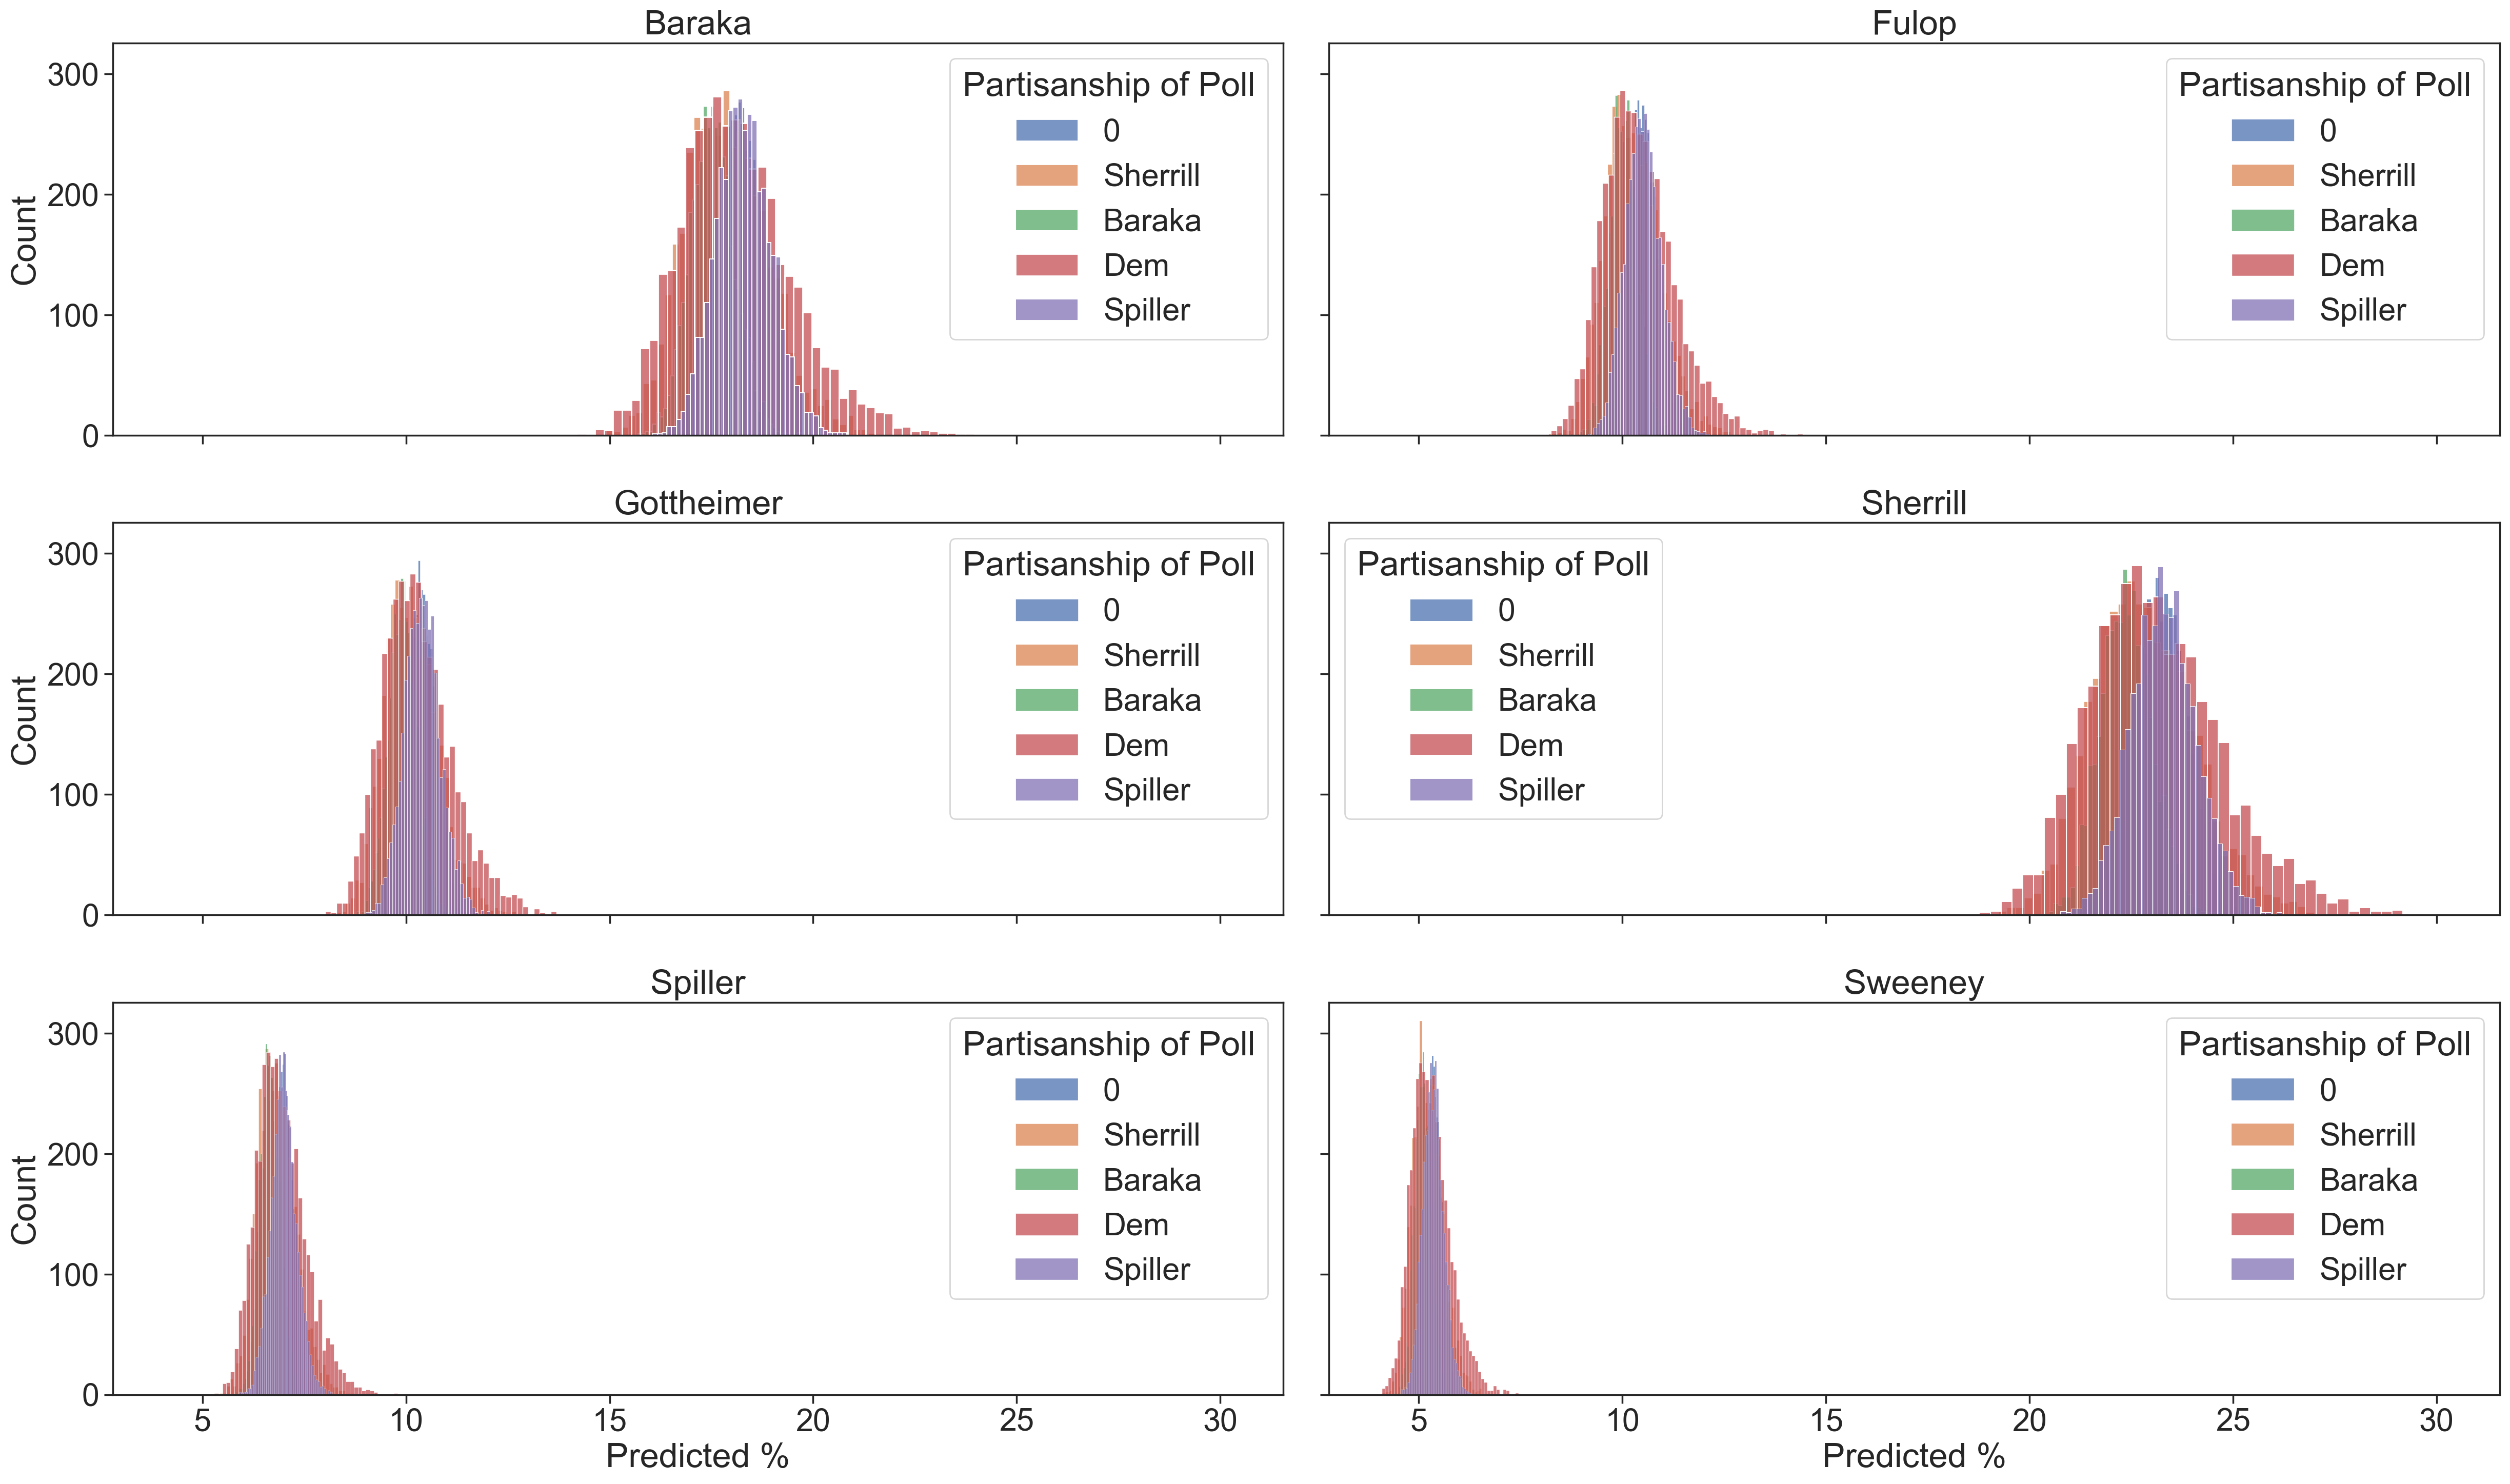

In [39]:
(fig, axs) = plt.subplots(3, 2, sharex=True, sharey=True)
for (cand, ax) in zip(cand_preds, axs.ravel()):
    for kind in cand_preds[cand]:
        sns.histplot(x=cand_preds[cand][kind] * 100, label=kind, ax=ax)
    ax.set_title(cand)
    ax.legend(title="Partisanship of Poll")
    ax.set_xlabel("Predicted %")

plt.tight_layout()

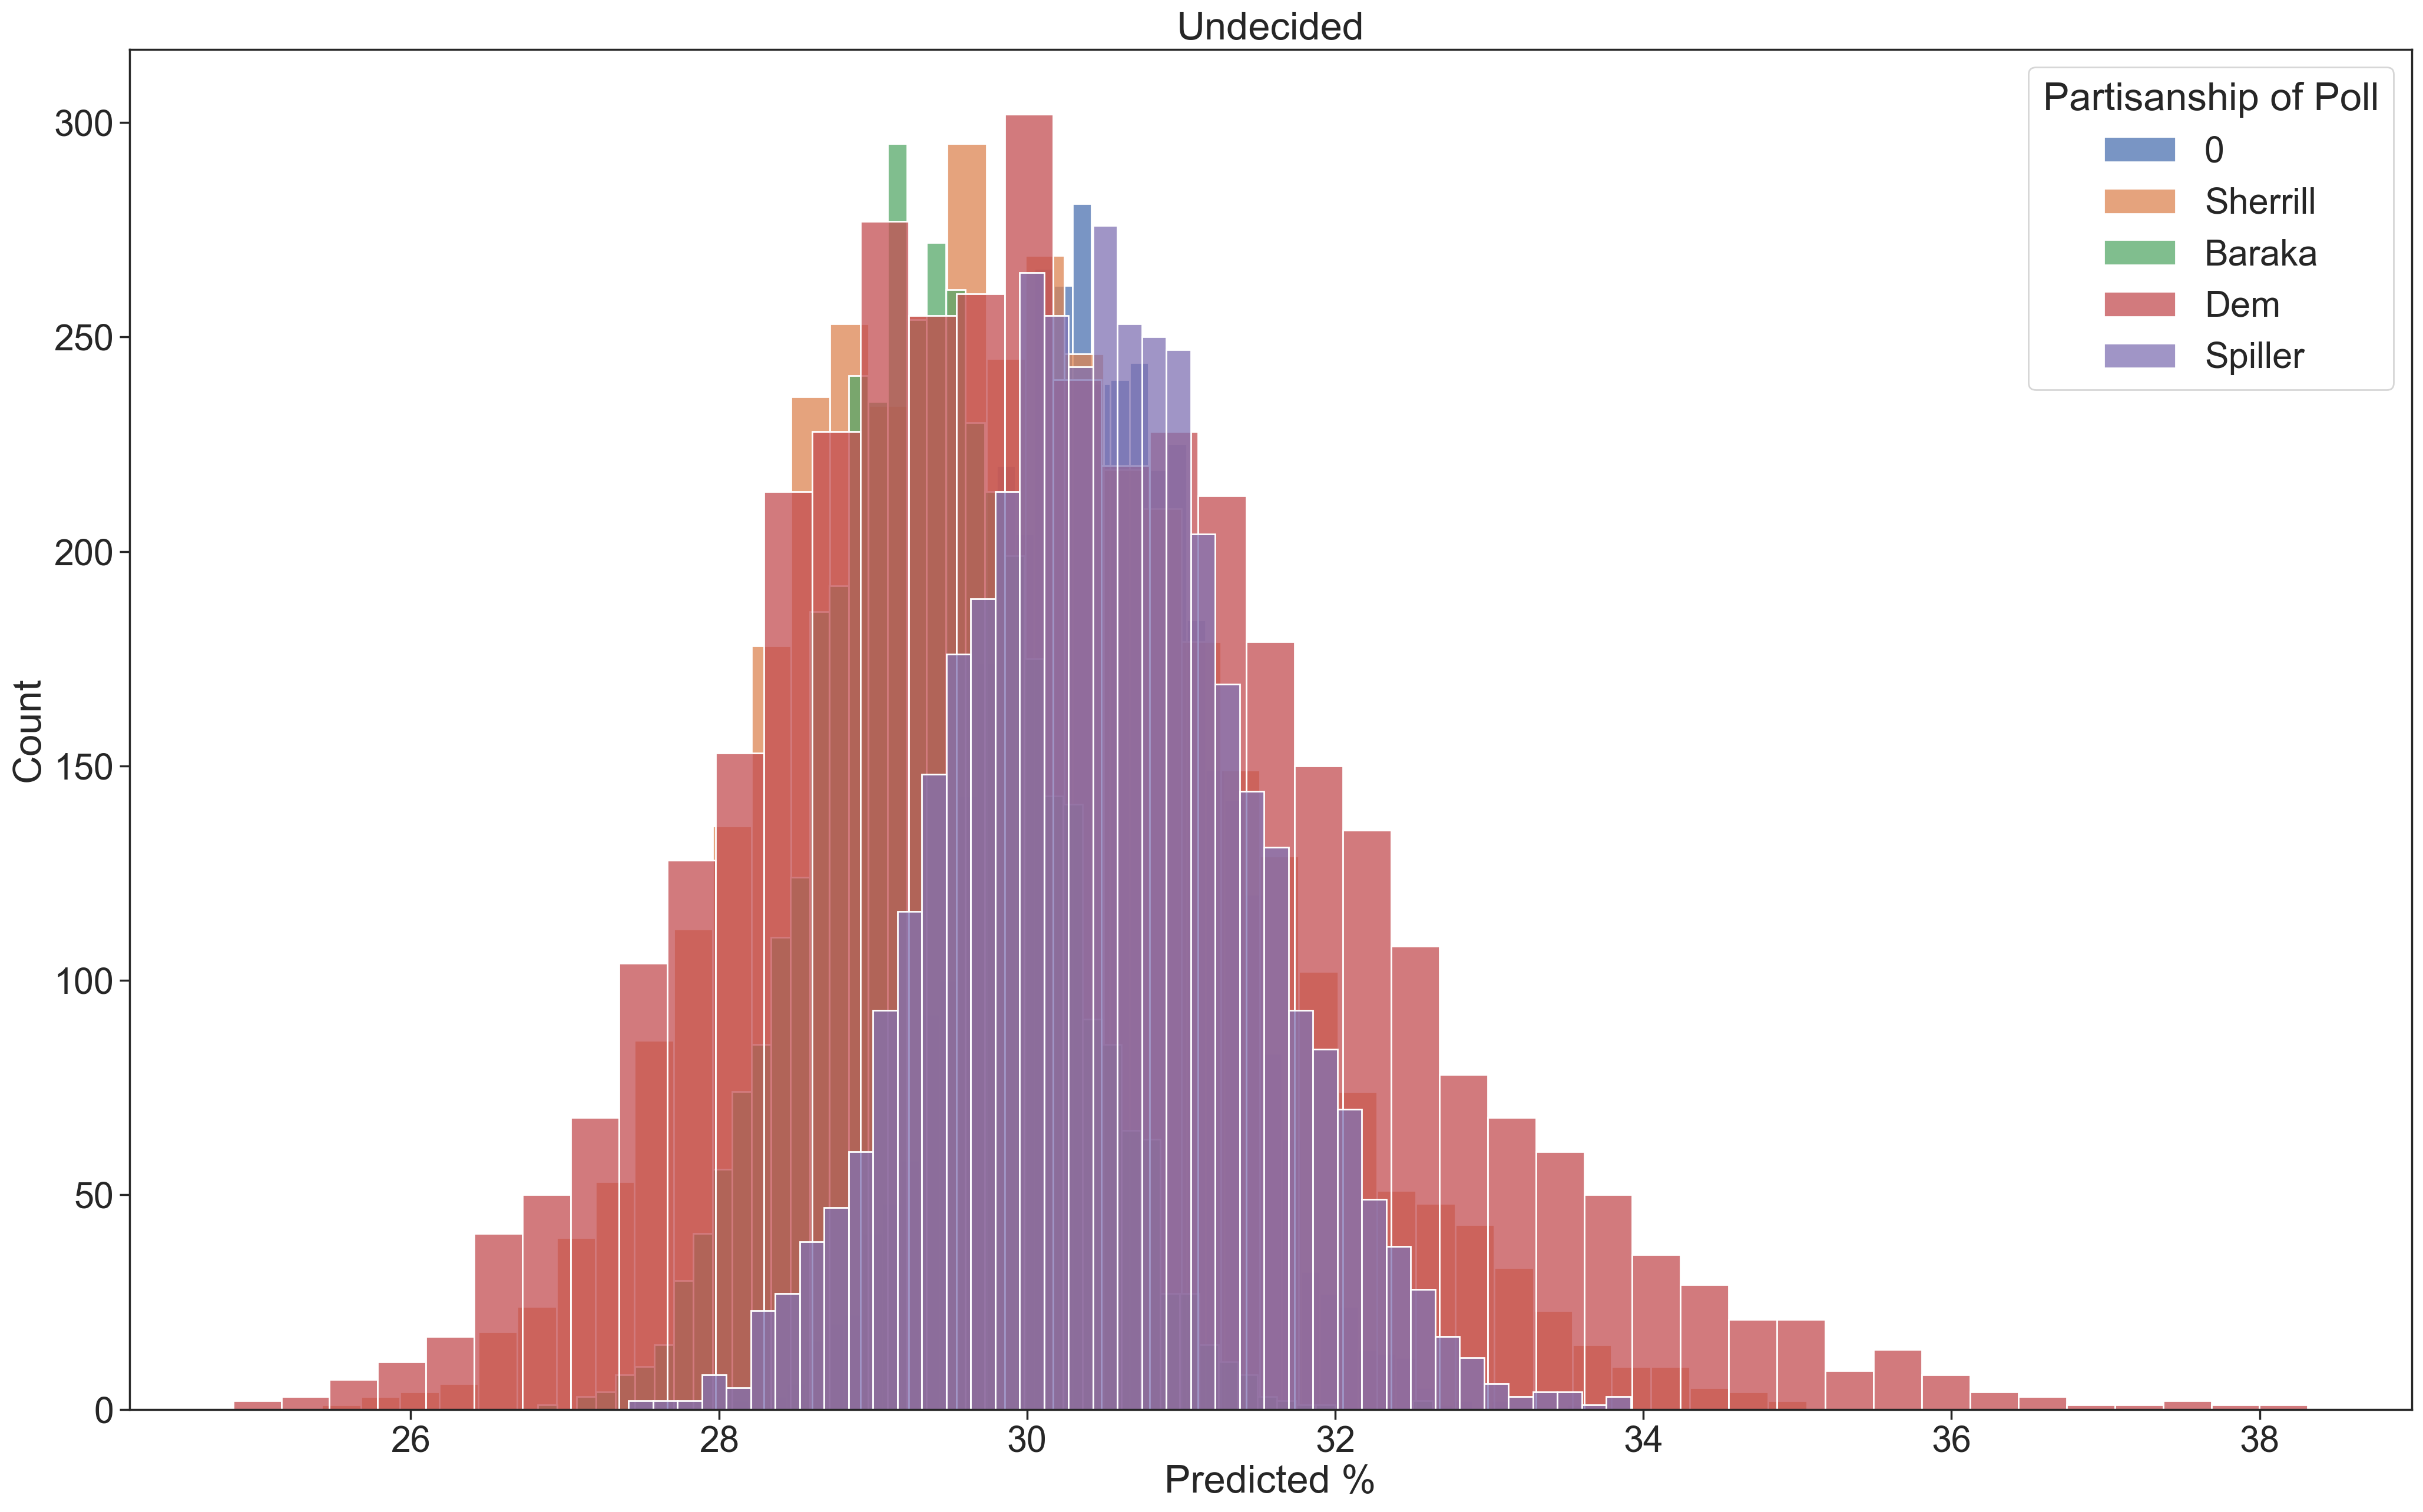

In [40]:
(fig, ax) = plt.subplots(1, 1)
for kind in cand_preds["Undecided"]:
    sns.histplot(x=cand_preds["Undecided"][kind] * 100, label=kind, ax=ax)
ax.set_title("Undecided")
ax.legend(title="Partisanship of Poll")
ax.set_xlabel("Predicted %")
plt.show()

In [41]:
rows = []
for cand in cand_preds:
    x = np.mean(np.stack([cand_preds[cand][k] for k in cand_preds[cand]]), axis=0)
    row = {"Candidate" : cand, "Pred" : np.mean(x), "Lower" : np.quantile(x, 0.025), "Upper" : np.quantile(x, 0.975)}
    rows.append(row)
pred_df = pandas.DataFrame(rows)

In [42]:
pred_df.sort_values(by=["Pred"], ascending=False)

Candidate      Pred     Lower     Upper
6   Undecided  0.300861  0.294569  0.307402
3    Sherrill  0.229663  0.223862  0.235609
0      Baraka  0.180186  0.175081  0.185548
1       Fulop  0.103367  0.099649  0.107185
2  Gottheimer  0.102183  0.098265  0.106309
4     Spiller  0.068822  0.065799  0.072080
5     Sweeney  0.052655  0.050067  0.055358